In [ ]:
#! pip install gcsfs

In [2]:
#! pip install koreanize_matplotlib

In [3]:
#!pip install seaborn

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os
import ast # 문자열을 리스트로 변환(출석 테이블)


In [9]:
# Pandas 보기 옵션
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
# GCP 키 경로
key_path = "../config/key.json"

# 1. accounts_attendance 출석 테이블 

In [21]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_attendance.parquet"
# 데이터 불러오기
accounts_attendance_df = pd.read_parquet(gcs_path, storage_options={"token": None}) # key_path // 오늘은 에러나서 None으로...

# 확인
display(accounts_attendance_df.head())
accounts_attendance_df.shape

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


(349637, 3)

In [ ]:
accounts_attendance_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [198]:
accounts_attendance_df.iloc[:,1:].duplicated().sum() # 중복값 없음

np.int64(0)

In [67]:
# 유저별 출석 횟수, 첫 출석일, 마지막 출석일 구하기

check_df = accounts_attendance_df.copy()

# attendance_date_list 리스트로 변환
check_df['attendance_date_list_transform'] = check_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 
check_df['attend_cnt'] = check_df['attendance_date_list_transform'].apply(len)

# 첫 출석, 마지막 출석 컬럼 추가
check_df['first_date'] = check_df['attendance_date_list_transform'].apply(lambda x: x[0] if len(x) > 0 else None)
check_df['last_date'] = check_df['attendance_date_list_transform'].apply(lambda x: x[-1] if len(x) > 0 else None)
    
# 날짜 타입으로 변환 
check_df['first_date'] = pd.to_datetime(check_df['first_date'])
check_df['last_date'] = pd.to_datetime(check_df['last_date'])

# 마지막 출석일과 첫 출석일 차이 구하기
check_df['attend_days'] = (check_df['last_date'] - check_df['first_date']).dt.days

check_df.head()


,id,attendance_date_list,user_id,attendance_date_list_transform,attend_cnt,first_date,last_date,attend_days
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",13,2023-05-27,2023-09-19,115.0
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398,"[2023-05-27, 2023-05-29, 2023-05-30, 2023-06-0...",33,2023-05-27,2023-08-22,87.0
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542,"[2023-05-27, 2023-05-29, 2023-05-30, 2023-05-3...",9,2023-05-27,2023-06-14,18.0
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",30,2023-05-27,2023-06-30,34.0
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",31,2023-05-27,2023-06-28,32.0


In [68]:
check_df.describe()

,id,user_id,attend_cnt,first_date,last_date,attend_days
count,349637.000000,3.496370e+05,349637.000000,328692,328692,328692.000000
mean,180550.143772,1.247187e+06,6.356098,2023-06-03 05:13:37.100507136,2023-06-30 04:34:26.605819648,26.972795
min,1.000000,8.321510e+05,0.000000,2023-05-27 00:00:00,2023-05-27 00:00:00,0.000000
25%,90432.000000,1.065813e+06,1.000000,2023-05-28 00:00:00,2023-06-01 00:00:00,1.000000
50%,180749.000000,1.261234e+06,3.000000,2023-05-29 00:00:00,2023-06-08 00:00:00,8.000000
75%,270674.000000,1.437486e+06,8.000000,2023-05-30 00:00:00,2023-07-08 00:00:00,27.000000
max,360505.000000,1.583730e+06,310.000000,2024-05-09 00:00:00,2024-05-09 00:00:00,348.000000
std,104168.322237,2.127986e+05,9.158459,NaN,NaN,47.314662


- attend_cnt : 출석을 한번도 하지 않은 경우도 데이터에 존재!, 최대 310번 출석한 유저 존재
- first_date : 23년 5월 27일 ~ 30일 사이에 대부분 첫 출석
- last_date : 23년 5월 27일 ~ 23년 7월 8일 사이에 대부분 마지막 출석 => 약 한두달 짧게 이용하고 빠짐 / 24년 5월 9일이 마지막 출석인 경우도 존재
- attend_days : 첫 출석과 마지막 출석 사이 기간이 대부분 길지 않음! 한달 이내 / 348일 이용한 경우도 존재

# 2. accounts_blockrecord : 차단 기록 테이블

In [70]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_blockrecord.parquet"
# 데이터 불러오기
accounts_blockrecord_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_blockrecord_df.head())
accounts_blockrecord_df.shape

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


(19482, 5)

In [73]:
accounts_blockrecord_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [203]:
accounts_blockrecord_df.iloc[:,1:].duplicated().sum() # 중복값 5개

np.int64(5)

In [ ]:
# 중복 확인
accounts_blockrecord_df[accounts_blockrecord_df.iloc[:,1:].duplicated(keep = False)]

,id,reason,created_at,block_user_id,user_id
1125,1509,모르는 사람임,2023-05-08 06:31:49,977940,967723
1126,1510,모르는 사람임,2023-05-08 06:31:49,977940,967723
1882,2555,모르는 사람임,2023-05-09 11:55:42,1025677,971524
1883,2556,모르는 사람임,2023-05-09 11:55:42,1025677,971524
1884,2557,모르는 사람임,2023-05-09 11:55:43,1025677,971524
1885,2558,모르는 사람임,2023-05-09 11:55:43,1025677,971524
1886,2559,모르는 사람임,2023-05-09 11:55:43,1025677,971524
4615,6161,모르는 사람임,2023-05-13 14:54:47,931725,859334
4616,6162,모르는 사람임,2023-05-13 14:54:47,931725,859334


In [75]:
accounts_blockrecord_df.describe() 

,id,created_at,block_user_id,user_id
count,19482.000000,19482,1.948200e+04,1.948200e+04
mean,12694.563495,2023-05-25 19:12:26.516579584,1.183576e+06,1.175780e+06
min,1.000000,2023-05-04 23:01:53,8.327400e+05,8.376150e+05
25%,6514.250000,2023-05-14 02:19:01,1.001336e+06,9.890410e+05
50%,12731.000000,2023-05-22 11:37:20,1.173390e+06,1.160726e+06
75%,18984.750000,2023-05-28 11:04:33,1.357468e+06,1.345758e+06
max,25361.000000,2024-05-06 13:03:37,1.582869e+06,1.583612e+06
std,7220.338199,NaN,2.049517e+05,2.043189e+05


- 2023-05-04 ~ 2024-05-06 데이터

In [77]:
# 차단한 이유별 건수
accounts_blockrecord_df['reason'].value_counts().reset_index()

,reason,count
0,모르는 사람임,9640
1,친구 사이가 어색해짐,5805
2,사칭 계정,2022
3,나랑 관련 없는 질문을 자꾸 보냄,1083
4,너무 많은 양의 질문을 보냄,919
5,기타,7
6,그냥...,6


- "모르는 사람임" 이유 1위 -> 모르는 사람인데도 차단하기 이전에 친구가 된건가??
- "친구 사이가 어색해짐" 이유 2위 -> 10대 청소년의 친구관계의 문제? 

In [15]:
# 년-월별 차단 건수 체크 
check_df = accounts_blockrecord_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-05    16442
2023-06     2262
2023-07      410
2023-08      159
2023-09      103
2023-10       11
2023-11       16
2023-12        9
2024-01        9
2024-02       12
2024-03       35
2024-04       12
2024-05        2
Freq: M, Name: count, dtype: int64

- 갈수록 차단 건수가 줄어듦
- 2023-05에 차단 건수 가장 많았음(16,442건)

# 3. accounts_failpaymenthistory : 상품 구매 실패 기록 테이블

In [79]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_failpaymenthistory.parquet"
# 데이터 불러오기
accounts_failpaymenthistory_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_failpaymenthistory_df.head())
accounts_failpaymenthistory_df.shape

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


(163, 5)

In [ ]:
accounts_failpaymenthistory_df.info() # procudtId 결측치 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [ ]:
display(accounts_failpaymenthistory_df.iloc[:,1:].duplicated().sum()) # 중복 1개

# 중복 확인
accounts_failpaymenthistory_df[accounts_failpaymenthistory_df.iloc[:,1:].duplicated(keep = False)]

np.int64(1)

,id,productId,phone_type,created_at,user_id
161,173,None,I,2023-09-17 09:12:53,927108
162,174,None,I,2023-09-17 09:12:53,927108


In [ ]:
accounts_failpaymenthistory_df.describe()

,id,created_at,user_id
count,163.000000,163,1.630000e+02
mean,89.828221,2023-05-27 11:32:20.828220672,1.263685e+06
min,6.000000,2023-05-14 05:49:22,8.341120e+05
25%,48.500000,2023-05-18 11:34:05,1.152704e+06
50%,89.000000,2023-05-22 08:54:33,1.273301e+06
75%,131.500000,2023-05-29 12:58:21.500000,1.398432e+06
max,174.000000,2023-09-17 09:12:53,1.575434e+06
std,48.494316,NaN,1.824636e+05


- 2023-05-27 ~ 2023-09-17 데이터

In [ ]:
accounts_failpaymenthistory_df['productId'].unique() # 상품  = 하트?  

array(['heart.200', 'heart.777', 'heart.1000', None], dtype=object)

In [ ]:
accounts_failpaymenthistory_df['phone_type'].unique() # A : 안드로이드, I : ios 추정

array(['A', 'I'], dtype=object)

In [ ]:
# 년-월별 상품 구매 실패 건수 체크 
check_df = accounts_failpaymenthistory_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-05    141
2023-06     14
2023-07      4
2023-08      2
2023-09      2
Freq: M, Name: count, dtype: int64

- 2023-05에 가장 구매 실패 기록 많음

# 4. accounts_friendrequest 친구 요청 테이블

In [5]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_friendrequest.parquet"
# 데이터 불러오기
accounts_friendrequest_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_friendrequest_df.head())
accounts_friendrequest_df.shape

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


(17147175, 6)

In [83]:
accounts_friendrequest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147175 entries, 0 to 17147174
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   status           object        
 2   created_at       datetime64[ns]
 3   updated_at       datetime64[ns]
 4   receive_user_id  int64         
 5   send_user_id     int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 784.9+ MB


In [ ]:
accounts_friendrequest_df.isnull().sum() # 결측치 없음

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [6]:
display(accounts_friendrequest_df.iloc[:,1:].duplicated().sum()) # 중복 63개

# 중복 확인
accounts_friendrequest_df[accounts_friendrequest_df.iloc[:,1:].duplicated(keep = False)]

np.int64(63)

,id,status,created_at,updated_at,receive_user_id,send_user_id
2366999,2774527,P,2023-05-08 04:38:36,2023-05-08 04:38:36,899664,990693
2367000,2774528,P,2023-05-08 04:38:36,2023-05-08 04:38:36,906947,990693
2367018,2774547,P,2023-05-08 04:38:36,2023-05-08 04:38:36,973428,990693
2367019,2774548,P,2023-05-08 04:38:36,2023-05-08 04:38:36,984810,990693
2367020,2774549,P,2023-05-08 04:38:36,2023-05-08 04:38:36,987062,990693
...,...,...,...,...,...,...
17113165,19657840,P,2023-11-13 12:48:34,2023-11-13 12:48:34,1350806,1581706
17113166,19657841,P,2023-11-13 12:48:34,2023-11-13 12:48:34,1351398,1581706
17113167,19657842,P,2023-11-13 12:48:34,2023-11-13 12:48:34,1424868,1581706
17113168,19657843,P,2023-11-13 12:48:34,2023-11-13 12:48:34,1468396,1581706


In [12]:
accounts_friendrequest_df[(accounts_friendrequest_df['send_user_id'] == 990693) & (accounts_friendrequest_df['receive_user_id'] == 899664)]

,id,status,created_at,updated_at,receive_user_id,send_user_id
2366999,2774527,P,2023-05-08 04:38:36,2023-05-08 04:38:36,899664,990693
2367027,2774556,P,2023-05-08 04:38:36,2023-05-08 04:38:36,899664,990693


In [ ]:
accounts_friendrequest_df.describe(include='all')

,id,status,created_at,updated_at,receive_user_id,send_user_id
count,1.714718e+07,17147175,17147175,17147175,1.714718e+07,1.714718e+07
unique,NaN,3,NaN,NaN,NaN,NaN
top,NaN,A,NaN,NaN,NaN,NaN
freq,NaN,12878407,NaN,NaN,NaN,NaN
mean,9.855565e+06,NaN,2023-05-17 19:14:14.416623360,2023-05-19 03:18:26.881183232,1.154812e+06,1.215895e+06
min,7.000000e+00,NaN,2023-04-17 18:29:11,2023-04-17 18:29:11,8.319620e+05,8.319620e+05
25%,4.940746e+06,NaN,2023-05-10 10:53:21,2023-05-11 03:51:13,9.737080e+05,1.029359e+06
50%,9.810449e+06,NaN,2023-05-15 10:38:56,2023-05-16 10:24:42,1.138343e+06,1.213751e+06
75%,1.477598e+07,NaN,2023-05-22 14:28:30,2023-05-23 21:37:16,1.317869e+06,1.405678e+06
max,1.969298e+07,NaN,2024-05-09 09:21:47,2024-05-09 09:21:47,1.583731e+06,1.583732e+06


- 2023-05-17 ~ 2024-05-09 데이터
- status : A(수락)인 상태가 가장 많음

In [ ]:
# 상태 별 개수 확인 
# A 수락, P 대기, R 거절
accounts_friendrequest_df['status'].value_counts()

status
A    12878407
P     3938608
R      330160
Name: count, dtype: int64

- A (수락) 상태인 경우가 가장 많음
- 수락 -> 대기 -> 거절 상태 순으로 많음

In [14]:
# 친구 요청 일시와 업데이트 일시 차이 
accounts_friendrequest_df['diff'] = (accounts_friendrequest_df['updated_at'] - accounts_friendrequest_df['created_at'])
accounts_friendrequest_df.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id,diff
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521,0 days 00:00:00
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521,4 days 11:33:42
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521,1 days 00:59:30
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521,1 days 16:35:53
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521,0 days 00:00:00


In [ ]:
# 전체 데이터에 대한 describe
accounts_friendrequest_df['diff'].describe()

count                     17147175
mean     1 days 08:04:12.464558564
std      6 days 16:19:52.710429663
min                0 days 00:00:00
25%                0 days 00:01:36
50%                0 days 01:56:52
75%                0 days 17:09:57
max              362 days 12:36:08
Name: diff, dtype: object

- 약 50% 정도는 약 2시간 안에 업데이트가 이루어짐 
- 친구 요청 일시와 업데이트 일시에 최대 362일 차이가 나는 경우 존재???!!

In [100]:
# 수락 또는 거절이 있어야 update? 
accounts_friendrequest_df[accounts_friendrequest_df['status'] != 'P'].head(20)

,id,status,created_at,updated_at,receive_user_id,send_user_id,diff
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521,4 days 11:33:42
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521,1 days 00:59:30
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521,1 days 16:35:53
7,46,A,2023-04-18 06:44:18,2023-06-01 01:14:53,835871,837523,43 days 18:30:35
8,53,A,2023-04-19 05:55:30,2023-04-19 08:47:32,835869,837524,0 days 02:52:02
9,54,A,2023-04-19 06:06:20,2023-04-19 06:06:31,837530,837532,0 days 00:00:11
10,55,A,2023-04-19 06:06:26,2023-04-19 06:33:23,833202,837534,0 days 00:26:57
11,56,A,2023-04-19 06:06:26,2023-05-04 09:29:25,833714,837534,15 days 03:22:59
13,58,A,2023-04-19 06:06:26,2023-05-04 12:03:02,834288,837534,15 days 05:56:36
14,59,A,2023-04-19 06:06:26,2023-04-30 12:37:14,835714,837534,11 days 06:30:48


In [15]:
accounts_friendrequest_df[accounts_friendrequest_df['status'] != 'P']['diff'].describe()

count                     13208567
mean     1 days 17:37:58.757764562
std      7 days 13:35:06.897985564
min                0 days 00:00:01
25%                0 days 00:55:29
50%                0 days 05:47:30
75%                1 days 00:32:48
max              362 days 12:36:08
Name: diff, dtype: object

In [16]:
accounts_friendrequest_df[accounts_friendrequest_df['status'] != 'P']['diff'].value_counts()

diff
0 days 00:00:08     5155
0 days 00:00:09     5130
0 days 00:00:07     5127
0 days 00:00:10     5118
0 days 00:00:11     5018
                    ... 
4 days 04:17:23        1
12 days 13:08:09       1
14 days 19:09:49       1
69 days 02:08:19       1
21 days 01:57:15       1
Name: count, Length: 1098778, dtype: int64

- 최솟값이 1초이긴 함... 1초만에 수락 또는 거절 의사 표시?
- 그래도 1분위수가 55분! 어쨋든 뭔가 액션을 취해야 업데이트 되나봄

In [96]:
# P 대기 상태인 경우 created_at == updated_at일까?
accounts_friendrequest_df[accounts_friendrequest_df['status'] == 'P']['diff'].value_counts()

diff
0 days 00:00:00    3938451
0 days 00:00:01        157
Name: count, dtype: int64

- 친구 요청 후, "대기" 상태인 경우 대부분 created_at, updated_at 차이가 없음!
- 157건만 1초 차이남

# 5. accounts_group : 학급 테이블

In [81]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_group.parquet"
# 데이터 불러오기
accounts_group_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_group_df.head())
accounts_group_df.shape

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


(84515, 4)

In [ ]:
accounts_group_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84515 entries, 0 to 84514
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         84515 non-null  int64
 1   grade      84515 non-null  int64
 2   class_num  84515 non-null  int64
 3   school_id  84515 non-null  int64
dtypes: int64(4)
memory usage: 2.6 MB


In [ ]:
display(accounts_group_df.iloc[:,1:].duplicated().sum()) # 중복 5개

# 중복 확인
accounts_group_df[accounts_group_df.iloc[:,1:].duplicated(keep = False)]

np.int64(5)

,id,grade,class_num,school_id
58686,58711,1,4,4383
58699,58724,1,1,5899
58902,58927,3,1,5900
73208,73234,3,1,5900
75735,75762,3,1,4383
76437,76464,1,4,4383
77093,77120,1,1,5899
79779,79806,3,1,4383
80781,80809,2,20,5900
82087,82115,2,20,5900


In [142]:
accounts_group_df.describe()

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [143]:
# 학교 아이디별 개수
accounts_group_df['school_id'].value_counts()

school_id
3283    49
1773    44
1492    44
5223    43
2212    43
        ..
1109     1
1299     1
4388     1
3654     1
763      1
Name: count, Length: 5604, dtype: int64

In [144]:
# 학년별 개수
accounts_group_df['grade'].value_counts()

grade
2     35581
3     29273
1     19659
4         1
20        1
Name: count, dtype: int64

- 1,2,3 학년만 있는게 아니라 4, 20도 존재?

In [146]:
display(accounts_group_df[accounts_group_df['grade'] == 4])
display(accounts_group_df[accounts_group_df['grade'] == 20])

,id,grade,class_num,school_id
32624,32644,4,10,4658


,id,grade,class_num,school_id
61622,61647,20,7,3867


# 6. accounts_nearbyschool : 가까운 학교 기록 위한 관계형 테이블

In [146]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_nearbyschool.parquet"
# 데이터 불러오기
accounts_nearbyschool_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_nearbyschool_df.head())
accounts_nearbyschool_df.shape

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


(59500, 4)

In [ ]:
accounts_nearbyschool_df.info() # 결측 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59500 entries, 0 to 59499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                59500 non-null  int64  
 1   distance          59500 non-null  float64
 2   nearby_school_id  59500 non-null  int64  
 3   school_id         59500 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.8 MB


In [ ]:
display(accounts_nearbyschool_df.iloc[:,1:].duplicated().sum()) # 중복 없음

# 중복 확인
accounts_nearbyschool_df[accounts_nearbyschool_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,distance,nearby_school_id,school_id


In [169]:
accounts_nearbyschool_df['distance'].describe()

count    59500.000000
mean         0.055338
std          0.604024
min          0.000000
25%          0.011484
50%          0.021658
75%          0.064555
max         49.296594
Name: distance, dtype: float64

- distance 단위는 모르겠지만 대부분 가까운 편인듯
- distance가 0인 경우??
- distance 최대 49

In [ ]:
# distance 최댓값 확인
accounts_nearbyschool_df[accounts_nearbyschool_df['distance'] == accounts_nearbyschool_df['distance'].max()]

,id,distance,nearby_school_id,school_id
59308,178329,49.296594,615,5948


In [ ]:
# distance 0인 경우 확인
check_df = accounts_nearbyschool_df[accounts_nearbyschool_df['distance'] == 0]
display(check_df.shape)
check_df[check_df['nearby_school_id'] == check_df['school_id']]

(6214, 4)

,id,distance,nearby_school_id,school_id
9,119030,0.0,7,7
19,119040,0.0,8,8
29,119050,0.0,22,22
39,119060,0.0,13,13
49,119070,0.0,20,20
...,...,...,...,...
59459,178480,0.0,5959,5959
59469,178490,0.0,5960,5960
59479,178500,0.0,5964,5964
59489,178510,0.0,5963,5963


In [ ]:
# 학교별 가까운 학교 개수 구하기 
accounts_nearbyschool_df.groupby('school_id').size().describe()

count    5950.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
dtype: float64

# 7. accounts_paymenthistory : 구매 기록 테이블

In [153]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_paymenthistory.parquet"
# 데이터 불러오기
accounts_paymenthistory_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_paymenthistory_df.head())
accounts_paymenthistory_df.shape

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


(95140, 5)

In [ ]:
accounts_paymenthistory_df.info() # 결측 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB


In [ ]:
display(accounts_paymenthistory_df.iloc[:,1:].duplicated().sum()) # 중복 531개

# 중복 확인
accounts_paymenthistory_df[accounts_paymenthistory_df.iloc[:,1:].duplicated(keep = False)]

np.int64(531)

,id,productId,phone_type,created_at,user_id
30912,31938,heart.200,I,2023-05-17 13:46:11,1293409
30913,31939,heart.200,I,2023-05-17 13:46:11,1293409
35058,36213,heart.1000,I,2023-05-18 13:45:36,979577
35059,36214,heart.1000,I,2023-05-18 13:45:36,979577
90093,92999,heart.1000,I,2023-07-11 05:04:19,1556526
...,...,...,...,...,...
95132,98071,heart.777,I,2024-05-06 05:19:14,1398516
95134,98073,heart.777,I,2024-05-06 14:51:27,1086654
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [157]:
accounts_paymenthistory_df.describe()

,id,created_at,user_id
count,95140.000000,95140,9.514000e+04
mean,49136.797572,2023-05-27 21:47:32.003741952,1.256912e+06
min,6.000000,2023-05-13 21:28:34,8.330410e+05
25%,24531.750000,2023-05-16 11:48:44.750000128,1.116654e+06
50%,49176.500000,2023-05-21 12:40:45.500000,1.270988e+06
75%,73740.250000,2023-05-27 13:02:52.249999872,1.417660e+06
max,98078.000000,2024-05-08 14:12:45,1.583632e+06
std,28366.854064,NaN,1.911243e+05


- 2023-05-13 ~ 2024-05-08 데이터 

In [ ]:
# 프로덕트 아이디별 개수
accounts_paymenthistory_df['productId'].value_counts()

productId
heart.777     57873
heart.1000    19309
heart.200     15822
heart.4000     2136
Name: count, dtype: int64

# 8. accounts_user_contacts : 유저 컨택 테이블

In [17]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_user_contacts.parquet"
# 데이터 불러오기
accounts_user_contacts_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_user_contacts_df.head())
accounts_user_contacts_df.shape

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


(5063, 4)

In [215]:
accounts_user_contacts_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [ ]:
display(accounts_user_contacts_df.iloc[:,1:].duplicated().sum()) # 중복 없음

# 중복 확인
accounts_user_contacts_df[accounts_user_contacts_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,contacts_count,invite_user_id_list,user_id


In [218]:
accounts_user_contacts_df.describe()

,id,contacts_count,user_id
count,5.063000e+03,5063.000000,5.063000e+03
mean,2.840907e+06,25.986174,1.114789e+06
std,2.895428e+06,13.601434,2.187702e+05
min,2.590000e+02,0.000000,8.473750e+05
25%,7.475970e+05,16.000000,8.855155e+05
50%,1.580135e+06,24.000000,1.119987e+06
75%,4.201598e+06,34.000000,1.278826e+06
max,1.460827e+07,114.000000,1.583629e+06


In [18]:
# invite_user_id_list 리스트로 변환
accounts_user_contacts_df['invite_user_id_list_transform'] = accounts_user_contacts_df['invite_user_id_list'].apply(ast.literal_eval)
accounts_user_contacts_df['invite_user_count'] = accounts_user_contacts_df['invite_user_id_list_transform'].apply(len)
accounts_user_contacts_df.head()

,id,contacts_count,invite_user_id_list,user_id,invite_user_id_list_transform,invite_user_count
0,259,30,[],1167696,[],0
1,1756,79,[],863169,[],0
2,13742,21,[854615],857205,[854615],1
3,13754,29,[],851431,[],0
4,13756,28,[849318],855476,[849318],1


In [21]:
# 초대 누른 유저 수 
accounts_user_contacts_df['invite_user_count'].describe()

count    5063.000000
mean        0.333202
std         0.752303
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: invite_user_count, dtype: float64

In [221]:
# contacts_count (번호 갖고 있는 사람 수) 중 invite_user_count (초대 누른 사람) 비율
(accounts_user_contacts_df['invite_user_count'] / accounts_user_contacts_df['contacts_count']).describe()

count    5060.000000
mean        0.012140
std         0.030567
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

- 번호를 갖고 있어도 해당 번호 소유자를 초대하는 유저는 아주 드물다!

# 9. accounts_pointhistory : 포인트 기록 테이블

In [22]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_pointhistory.parquet"
# 데이터 불러오기
accounts_pointhistory_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_pointhistory_df.head())
accounts_pointhistory_df.shape

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


(2338918, 5)

In [186]:
accounts_pointhistory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [ ]:
accounts_pointhistory_df.isnull().sum() # user_question_record_id 결측치 !!

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [ ]:
display(accounts_pointhistory_df.iloc[:,1:].duplicated().sum()) # 중복 1939개

# 중복 확인
accounts_pointhistory_df[accounts_pointhistory_df.iloc[:,1:].duplicated(keep = False)]

np.int64(1939)

,id,delta_point,created_at,user_id,user_question_record_id
854313,77956321,5,2023-05-13 16:26:32,1198097,38953394.0
854314,77956327,5,2023-05-13 16:26:32,1198097,38953394.0
859532,78459033,9,2023-05-13 17:21:17,1234279,39197466.0
859533,78459034,9,2023-05-13 17:21:17,1234279,39197466.0
859737,78469857,13,2023-05-13 17:22:53,1234279,39202746.0
...,...,...,...,...,...
2337869,340463979,200,2024-01-06 14:21:47,875314,NaN
2337871,340463987,200,2024-01-06 14:23:09,875314,NaN
2337872,340463988,200,2024-01-06 14:23:09,875314,NaN
2338567,340599301,777,2024-02-27 14:41:47,1318890,NaN


In [224]:
accounts_pointhistory_df.describe()

,id,delta_point,created_at,user_id,user_question_record_id
count,2.338918e+06,2.338918e+06,2338918,2.338918e+06,2.335926e+06
mean,1.265364e+08,8.610862e-01,2023-05-18 03:06:43.825683968,1.111554e+06,6.141803e+07
min,7.906290e+05,-1.000000e+03,2023-04-28 12:27:49,8.380230e+05,7.717770e+05
25%,4.112505e+07,7.000000e+00,2023-05-11 04:37:02,8.861890e+05,2.088561e+07
50%,1.123971e+08,1.000000e+01,2023-05-16 07:29:11,1.126012e+06,5.540614e+07
75%,1.982051e+08,1.300000e+01,2023-05-22 13:47:48.750000128,1.260221e+06,9.555855e+07
max,3.406724e+08,1.000000e+03,2024-05-08 01:36:18,1.583358e+06,1.616665e+08
std,9.610992e+07,5.885849e+01,NaN,2.024429e+05,4.531970e+07


- 2023-04-28 ~ 2024-05-08 데이터 
- delta_point : 포인트 양 -인 경우도 존재??, 최댓값은 1000 정도 

In [41]:
# 투표 기록 id 가 null 인 경우 
accounts_pointhistory_df[accounts_pointhistory_df['user_question_record_id'].isnull()]

,id,delta_point,created_at,user_id,user_question_record_id
2309070,330683383,200,2023-06-22 09:01:32,1219402,NaN
2309385,330788563,200,2023-06-22 11:55:43,1120688,NaN
2310273,331188040,200,2023-06-23 13:03:45,927655,NaN
2310274,331188140,500,2023-06-23 13:03:58,927655,NaN
2310275,331188257,1000,2023-06-23 13:04:11,927655,NaN
...,...,...,...,...,...
2338780,340639422,50,2024-04-12 15:56:07,1131924,NaN
2338821,340644892,50,2024-04-20 07:45:21,1243339,NaN
2338822,340645302,50,2024-04-20 16:49:15,1136187,NaN
2338823,340645524,50,2024-04-21 04:40:53,874566,NaN


In [32]:
# 결측치 제거
accounts_pointhistory_df_notnull = accounts_pointhistory_df[~accounts_pointhistory_df.isnull().any(axis = 1)]

In [35]:
# 델타 포인트 음수인 부분
accounts_pointhistory_df_notnull[accounts_pointhistory_df_notnull['delta_point'] < 0].shape

(108582, 5)

In [37]:
# 델타 포인트 고유값 개수
accounts_pointhistory_df_notnull['delta_point'].nunique()

16

In [39]:
# 델타 포인트 고유값
accounts_pointhistory_df_notnull['delta_point'].value_counts()

delta_point
 6       203479
 9       203365
 10      203346
 5       203173
 7       202967
 11      202721
 13      202486
 12      202064
 14      201907
 8       200975
 15      200861
-300      40266
-10       39966
-200      20781
-500       6147
-1000      1422
Name: count, dtype: int64

# 10. accounts_school : 학교 테이블

In [77]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_school.parquet"
# 데이터 불러오기
accounts_school_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_school_df.head())
accounts_school_df.shape

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


(5951, 4)

In [ ]:
accounts_school_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5951 entries, 0 to 5950
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             5951 non-null   int64 
 1   address        5951 non-null   object
 2   student_count  5951 non-null   int64 
 3   school_type    5951 non-null   object
dtypes: int64(2), object(2)
memory usage: 186.1+ KB


In [ ]:
display(accounts_school_df.iloc[:,1:].duplicated().sum()) # 중복 458개 (존재할 수 있는 경우!)

# 중복 확인
accounts_school_df[accounts_school_df.iloc[:,1:].duplicated(keep = False)]

np.int64(458)

,id,address,student_count,school_type
11,15,충청북도 충주시,20,M
22,26,충청북도 충주시,0,H
26,30,충청북도 충주시,20,M
31,35,충청북도 충주시,0,H
101,105,충청북도 청주시 상당구,0,H
...,...,...,...,...
5915,5923,강원도 강릉시,197,H
5933,5947,경기도 성남시 분당구,0,H
5935,5949,-,1,H
5947,5961,인천광역시 서구,77,M


In [229]:
accounts_school_df.describe(include='all')

,id,address,student_count,school_type
count,5951.000000,5951,5951.000000,5951
unique,NaN,278,NaN,2
top,NaN,경기도 화성시,NaN,M
freq,NaN,78,NaN,3290
mean,2981.026046,NaN,113.772979,NaN
std,1719.084020,NaN,102.863428,NaN
min,4.000000,NaN,0.000000,NaN
25%,1493.500000,NaN,16.000000,NaN
50%,2981.000000,NaN,97.000000,NaN
75%,4469.500000,NaN,183.000000,NaN


- address : 경기도 화성시 학교가 많음
- student_count : 평균 113명 학생이 사용 / 최대 578명 
- school_type : M 중학교가 더 많음

In [93]:
# 중학교, 고등학교 개수 
accounts_school_df['school_type'].value_counts()

school_type
M    3290
H    2661
Name: count, dtype: int64

In [78]:
# 학년이 4, 20인 것 확인
accounts_school_df[accounts_school_df['id'].isin([4658, 3867])]

,id,address,student_count,school_type
3861,3867,경상북도 구미시,273,M
4651,4658,경기도 파주시,309,M


In [96]:
# 학생 수 0명인 경우
no_student_df = accounts_school_df[accounts_school_df['student_count'] == 0]
# 학교 수
display(no_student_df['id'].nunique())
# 중학교/고등학교 수
display(no_student_df['school_type'].value_counts())

387

school_type
H    195
M    192
Name: count, dtype: int64

# 11. accounts_timelinereport : 유저 신고기록 테이블

In [102]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_timelinereport.parquet"
# 데이터 불러오기
accounts_timelinereport_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_timelinereport_df.head())
accounts_timelinereport_df.shape

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


(208, 6)

In [103]:
accounts_timelinereport_df.info() # 결측치 없음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       208 non-null    int64         
 1   reason                   208 non-null    object        
 2   created_at               208 non-null    datetime64[ns]
 3   reported_user_id         208 non-null    int64         
 4   user_id                  208 non-null    int64         
 5   user_question_record_id  208 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.9+ KB


In [ ]:
display(accounts_timelinereport_df.iloc[:,1:].duplicated().sum()) # 중복 없음

# 중복 확인
accounts_timelinereport_df[accounts_timelinereport_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,reason,created_at,reported_user_id,user_id,user_question_record_id


In [105]:
accounts_timelinereport_df.describe()

,id,created_at,reported_user_id,user_id,user_question_record_id
count,208.000000,208,2.080000e+02,2.080000e+02,2.080000e+02
mean,9786.269231,2023-05-15 08:13:50.278846208,1.132497e+06,1.159946e+06,4.932558e+07
min,28.000000,2023-05-06 04:44:57,8.372350e+05,8.340890e+05,3.920588e+06
25%,6123.750000,2023-05-11 16:41:43.500000,9.664702e+05,9.671202e+05,2.461178e+07
50%,10095.000000,2023-05-15 01:23:29,1.144432e+06,1.184397e+06,4.740327e+07
75%,14182.250000,2023-05-18 18:01:18,1.225963e+06,1.291813e+06,7.179578e+07
max,23108.000000,2023-06-02 08:30:06,1.562736e+06,1.548002e+06,1.407659e+08
std,5713.767759,NaN,1.694121e+05,1.800959e+05,3.311281e+07


- 2023-05-15 ~ 2023-06-02 데이터 

In [ ]:
# 유저별 신고당한 개수
accounts_timelinereport_df['reported_user_id'].value_counts().sort_values(ascending = False).head(10)

reported_user_id
1138757    15
1156031     8
1187305     7
939196      7
885129      6
1225963     6
885473      5
1131675     4
1207784     4
1272969     3
Name: count, dtype: int64

In [107]:
# 많이 신고된 유저 경우 탐색  top3
print(accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 1138757]['reason'].value_counts())
print("------------------------")
print(accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 1156031]['reason'].value_counts())
print("------------------------")
print(accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 1187305]['reason'].value_counts())
print("------------------------")
print(accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 939196]['reason'].value_counts())
print("------------------------")
print(accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 885129]['reason'].value_counts())

reason
친구를 비하하거나 조롱하는 어투    15
Name: count, dtype: int64
------------------------
reason
선정적이거나 폭력적인 내용    7
허위 사실 언급          1
Name: count, dtype: int64
------------------------
reason
친구를 비하하거나 조롱하는 어투    3
선정적이거나 폭력적인 내용       2
허위 사실 언급             1
타인을 사칭함              1
Name: count, dtype: int64
------------------------
reason
허위 사실 언급    4
타인을 사칭함     3
Name: count, dtype: int64
------------------------
reason
허위 사실 언급             3
친구를 비하하거나 조롱하는 어투    1
타인을 사칭함              1
선정적이거나 폭력적인 내용       1
Name: count, dtype: int64


In [109]:
# 신고된 이유 별 개수
accounts_timelinereport_df['reason'].value_counts().sort_values(ascending = False).reset_index()

,reason,count
0,허위 사실 언급,80
1,친구를 비하하거나 조롱하는 어투,64
2,선정적이거나 폭력적인 내용,39
3,타인을 사칭함,15
4,광고,10


In [ ]:
# 년-월별 신고 건수 체크 
## 당연함!!! 23년 5월 데이터가 대부분임 애초에...;; 
check_df = accounts_timelinereport_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-05    206
2023-06      2
Freq: M, Name: count, dtype: int64

# 12. accounts_user : 유저 테이블

| columns            | explain                                     |
|--------------------|---------------------------------------------|
| is_superuser       | superuser인지 여부                          |
| is_staff           | staff인지 여부                              |
| firebase_uid       | 과거 firebase 세션관리 할때 사용하는 식별자 |
| gender             | 성별                                        |
| point              | 포인트                                      |
| friend_id_list     | 친구 id 데이터                              |
| is_push_on         | 푸시 on/off                                 |
| block_user_id_list | 차단한 유저 id 데이터                       |
| hide_user_id_list  | 숨김 처리한 유저 id 데이터                  |
| ban_status         | 차단 혹은 탈퇴한 유저인지 타입              |
| report_count       | 신고 당한 횟수                              |
| alarm_count        | 알람 갯수                                   |
| pending_chat       | 안 읽은 채팅 갯수                           |
| pending_votes      | 확인 안한 투표 갯수                         |
| group_id           | 학급 id                                     |
| created_at         | 만든 시간                                   |

In [42]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_user.parquet"
# 데이터 불러오기
accounts_user_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_user_df.head())
accounts_user_df.shape

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


(677085, 16)

In [112]:
accounts_user_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 no

In [43]:
accounts_user_df.isnull().sum()

id                    0
is_superuser          0
is_staff              0
gender                2
point                 0
friend_id_list        0
is_push_on            0
created_at            0
block_user_id_list    0
hide_user_id_list     0
ban_status            0
report_count          0
alarm_count           0
pending_chat          0
pending_votes         0
group_id              3
dtype: int64

In [44]:
accounts_user_df[accounts_user_df.isnull().any(axis = 1)]

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
138959,995177,0,0,F,600,[],1,2023-05-08 07:25:51.737820,[],[],N,0,0,0,0,NaN
674052,1580689,0,1,None,0,[],0,2023-09-24 17:39:12.897884,[],[],N,0,0,0,0,NaN


In [291]:
display(accounts_user_df.duplicated().sum()) # 중복 없음

# 중복 확인
accounts_user_df[accounts_user_df.duplicated(keep = False)]

np.int64(0)

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id


In [114]:
accounts_user_df.describe()

,id,is_superuser,is_staff,point,is_push_on,created_at,report_count,alarm_count,pending_chat,pending_votes,group_id
count,6.770850e+05,677085.000000,677085.000000,6.770850e+05,677085.000000,677085,677085.000000,677085.000000,677085.000000,677085.000000,677082.000000
mean,1.212969e+06,0.000003,0.000004,3.039145e+03,0.843098,2023-05-15 22:46:01.709213440,0.037291,0.946646,0.098469,84.630518,37022.980168
min,8.319560e+05,0.000000,0.000000,0.000000e+00,0.000000,2023-03-29 03:44:14.047130,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,1.028075e+06,0.000000,0.000000,4.000000e+02,1.000000,2023-05-09 01:35:23.126586880,0.000000,0.000000,0.000000,2.000000,18488.000000
50%,1.211729e+06,0.000000,0.000000,9.650000e+02,1.000000,2023-05-13 10:50:57.476214016,0.000000,1.000000,0.000000,29.000000,35614.000000
75%,1.397906e+06,0.000000,0.000000,2.183000e+03,1.000000,2023-05-20 07:49:47.800349952,0.000000,1.000000,0.000000,122.000000,54534.000000
max,1.583733e+06,1.000000,1.000000,8.850000e+08,1.000000,2024-05-09 08:31:17.710824,253.000000,40878.000000,5712.000000,3352.000000,84546.000000
std,2.138971e+05,0.001719,0.002105,1.076020e+06,0.363709,NaN,0.588105,56.114858,11.087769,123.262688,21997.765398


- point : 평균 3039 포인트 보유, 최고 885000~~ 보유 
- is_push_on : 푸시메시지 on 인 경우가 더 많음
- created_at : 2023-03-29 ~ 2024-05-09 데이터
- report_count : 신고당한 횟수 대부분 0 이지만, 최고 253 존재
- alarm_count : 알람 갯수 대부분 0 ~ 1 이지만, 최고 40878
- pending_chat : 안 읽은 채팅 갯수 대부분 없지만 최고 5712
- pending_votes :  확인 안한 투표 갯수 0 ~ 122 사이에 75% 존재, 최고 3352 


In [26]:
accounts_user_df.describe(include = 'O')

,gender,friend_id_list,block_user_id_list,hide_user_id_list,ban_status
count,677083,677085,677085,677085,677085
unique,2,674117,11685,74995,4
top,F,[],[],[],N
freq,396665,2874,664042,598352,668432


In [27]:
accounts_user_df['ban_status'].unique()

array(['N', 'NB', 'W', 'RB'], dtype=object)

- gender : F 여학생이 더 많음
- ban_status : 차단 혹은 탈퇴한 유저인지 타입 4개로 구분 (N, NB, W, RB) -> 무슨 뜻?

In [ ]:
# 유저 타입별 개수
accounts_user_df['ban_status'].value_counts()

ban_status
N     668432
W       7855
NB       608
RB       190
Name: count, dtype: int64

In [117]:
# 학급별 유저수 
accounts_user_df['group_id'].value_counts().head(10)

group_id
67097.0    80
6431.0     79
13705.0    73
53560.0    69
36957.0    61
51408.0    57
49683.0    57
59890.0    55
4021.0     54
41946.0    54
Name: count, dtype: int64

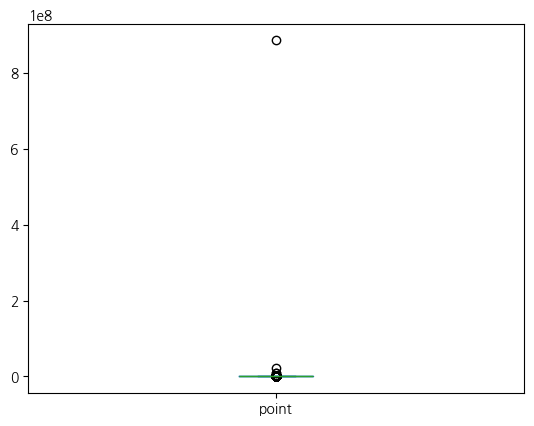

In [118]:
# 유저별 포인트  boxplot 
accounts_user_df['point'].plot(kind = 'box')
plt.show()

In [119]:
accounts_user_df[accounts_user_df['point'] > 800000000]

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
12,833041,0,0,F,885000006,"[841345, 982531, 838785, 882567, 832520, 87949...",1,2023-03-31 14:32:36.425315,[],[],N,1,8,0,0,149.0


- 포인트가 비정상적으로 많음
- 23년 3월 31일 가입
- superuser 또는 staff도 아닌데?

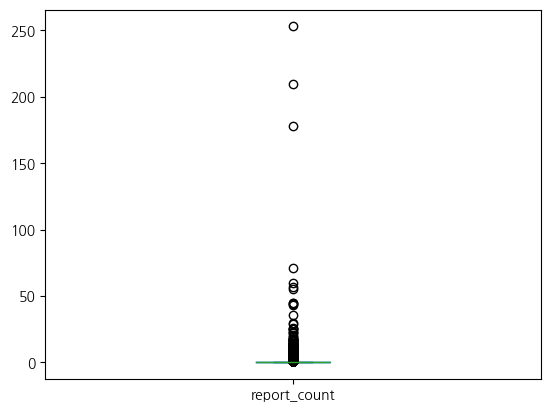

In [31]:
# 유저별 신고당한 횟수 boxplot 
accounts_user_df['report_count'].plot(kind = 'box')
plt.show()

In [32]:
# boxplot 기준 극단 이상치 확인 
accounts_user_df[accounts_user_df['report_count'] > 150]

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
50,834358,0,0,F,600426,"[841345, 982531, 832520, 838541, 846223, 83304...",1,2023-04-03 10:37:13.518521,[],[869100],N,210,912,5712,28,1.0
693,838541,0,0,F,100404,"[841345, 982531, 843015, 879496, 832520, 84429...",1,2023-04-19 16:36:39.906965,[],[],N,178,21442,4105,28,9.0


In [33]:
# 유저 테이블에서 신고당한 횟수 상위인 id가 유저 신고 기록테이블(23/5/15 ~ 23/6/2)에서는 데이터 없음 ! 기간 안맞는 문제!
accounts_timelinereport_df[accounts_timelinereport_df['reported_user_id'] == 838541]['reason'].value_counts()

Series([], Name: count, dtype: int64)

In [34]:
# iqr 기반 이상치 확인 
q3 = accounts_user_df['report_count'].quantile(0.75)
q1 = accounts_user_df['report_count'].quantile(0.25)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

#accounts_user_df[(accounts_user_df['report_count'] < lower) | (accounts_user_df['report_count'] > upper)]

In [35]:
# accounts_timelinereport_df; 유저 신고기록 테이블의 상위권 유저 탐색
target_user_list = [1138757, 1156031, 1187305, 939196, 885129]
accounts_user_df[accounts_user_df['id'].isin(target_user_list)]
      

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
37452,885129,0,0,M,698,"[883202, 883588, 885126, 888713, 883466, 90164...",0,2023-05-05 09:36:19.992098,[],[],N,6,0,0,33,12003.0
86960,939196,0,0,F,197,"[1051136, 1075719, 941581, 1058325, 1078814, 9...",1,2023-05-07 03:27:22.213022,[],[984978],N,7,0,0,536,21950.0
271434,1138757,0,0,F,1180,"[942080, 1158160, 1278994, 1136147, 1382424, 1...",1,2023-05-11 13:56:56.032360,[],[],N,15,1,0,122,24762.0
287357,1156031,0,0,M,917,"[1142661, 1156233, 1155992, 1175705, 1154585, ...",1,2023-05-12 02:52:55.364976,[],[],N,10,1,0,445,7399.0
316083,1187305,0,0,M,2598,"[1185408, 1180034, 1209858, 1006085, 1192968, ...",1,2023-05-12 15:57:28.105461,[],[],N,7,0,0,52,33241.0


# 13. accounts_userquestionrecord : 투표 기록 테이블

In [45]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_userquestionrecord.parquet"
# 데이터 불러오기
accounts_userquestionrecord_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_userquestionrecord_df.head())
accounts_userquestionrecord_df.shape

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


(1217558, 12)

In [ ]:
accounts_userquestionrecord_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217558 entries, 0 to 1217557
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1217558 non-null  int64         
 1   status             1217558 non-null  object        
 2   created_at         1217558 non-null  datetime64[ns]
 3   chosen_user_id     1217558 non-null  int64         
 4   question_id        1217558 non-null  int64         
 5   user_id            1217558 non-null  int64         
 6   question_piece_id  1217558 non-null  int64         
 7   has_read           1217558 non-null  int64         
 8   answer_status      1217558 non-null  object        
 9   answer_updated_at  1217558 non-null  datetime64[ns]
 10  report_count       1217558 non-null  int64         
 11  opened_times       1217558 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(2)
memory usage: 111.5+ MB


In [235]:
display(accounts_userquestionrecord_df.iloc[:,1:].duplicated().sum()) # 중복 없음

# 중복 확인
accounts_userquestionrecord_df[accounts_userquestionrecord_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times


In [236]:
accounts_userquestionrecord_df.describe()

,id,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_updated_at,report_count,opened_times
count,1.217558e+06,1217558,1.217558e+06,1.217558e+06,1.217558e+06,1.217558e+06,1.217558e+06,1217558,1.217558e+06,1.217558e+06
mean,5.957298e+07,2023-05-17 12:51:25.947102208,1.092604e+06,6.843895e+02,1.105790e+06,7.413211e+07,5.551530e-01,2023-05-17 13:44:38.920359680,1.765830e-04,6.332511e-02
min,7.717770e+05,2023-04-28 12:27:49,8.331120e+05,9.900000e+01,8.380230e+05,9.984580e+05,0.000000e+00,2023-04-28 12:27:49,0.000000e+00,0.000000e+00
25%,1.553965e+07,2023-05-10 01:42:11,8.836920e+05,2.750000e+02,8.846190e+05,1.854142e+07,0.000000e+00,2023-05-10 02:38:44.750000128,0.000000e+00,0.000000e+00
50%,5.302680e+07,2023-05-15 15:43:01.500000,1.091749e+06,4.690000e+02,1.117537e+06,6.616843e+07,1.000000e+00,2023-05-15 16:29:08.500000,0.000000e+00,0.000000e+00
75%,9.480960e+07,2023-05-22 11:01:03.750000128,1.235698e+06,9.420000e+02,1.259186e+06,1.176735e+08,1.000000e+00,2023-05-22 11:41:54.750000128,0.000000e+00,0.000000e+00
max,1.616665e+08,2024-05-08 01:36:18,1.579422e+06,5.133000e+03,1.583358e+06,2.083515e+08,1.000000e+00,2024-05-08 01:36:18,1.400000e+01,3.000000e+00
std,4.608193e+07,NaN,2.027585e+05,6.250399e+02,2.062704e+05,5.757237e+07,4.969490e-01,NaN,2.040530e-02,3.011468e-01


- 2023-04-28 ~ 2024-05-08 데이터
- has_read : 읽었는지 여부 절반은 1? 
- report_count : 신고 횟수 대부분 0, 최대 1.4? 소수점? 
- opened_times : 열어본 횟수 대부분 0, 최대 3

In [237]:
accounts_userquestionrecord_df.describe(include = 'O')

,status,answer_status
count,1217558,1217558
unique,3,3
top,C,N
freq,1156322,1097932


- status : 상태 C (닫힘)이 가장 많음     
c 닫힘, I 초성열림, B 차단 3가지     
- answer_status : 답장 상태 N (미답변)이 가장 많음     
N 미답변, P 비공개, A 공개

In [46]:
# 상태별 갯수
accounts_userquestionrecord_df['status'].value_counts()

status
C    1156322
I      60578
B        658
Name: count, dtype: int64

In [47]:
# 답장 상태별 갯수
accounts_userquestionrecord_df['answer_status'].value_counts()

answer_status
N    1097932
A     111761
P       7865
Name: count, dtype: int64

In [ ]:
# 투표에 미답변인 경우엔 created_at과 answer_updated_at 에 차이가 없나?
accounts_userquestionrecord_df[accounts_userquestionrecord_df['created_at'] == accounts_userquestionrecord_df['answer_updated_at']]['answer_status'].value_counts()



answer_status
N    1096506
Name: count, dtype: int64

In [ ]:
# 투표에 미답변 외에 비공개 or 공개 형태로 답변을 하면 created_at과 answer_updated_at 에 차이가 생기나?
accounts_userquestionrecord_df[accounts_userquestionrecord_df['created_at'] != accounts_userquestionrecord_df['answer_updated_at']]['answer_status'].value_counts()



answer_status
A    111761
P      7865
N      1426
Name: count, dtype: int64

- 투표에 답장을 하면 생성일시와 답장시간에 차이가 생김
- 투표에 미답변 상태이면 거의 생성일시 == 답장시간 이지만, 일부 차이가 있는 경우도 존재

# 14. accounts_userwithdraw : 탈퇴 기록 테이블

In [120]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/accounts_userwithdraw.parquet"
# 데이터 불러오기
accounts_userwithdraw_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(accounts_userwithdraw_df.head())
accounts_userwithdraw_df.shape

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


(70764, 3)

In [ ]:
accounts_userwithdraw_df.info() # 결측치 없음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70764 entries, 0 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          70764 non-null  int64         
 1   reason      70764 non-null  object        
 2   created_at  70764 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ MB


In [ ]:
display(accounts_userwithdraw_df.iloc[:,1:].duplicated().sum()) # 중복 369개

# 중복 확인
accounts_userwithdraw_df[accounts_userwithdraw_df.iloc[:,1:].duplicated(keep = False)]

np.int64(369)

,id,reason,created_at
429,476,기타 이유,2023-04-22 23:37:14
430,477,기타 이유,2023-04-22 23:37:14
1989,2060,기타 이유,2023-04-30 10:42:13
1990,2061,기타 이유,2023-04-30 10:42:13
2142,2215,기타 이유,2023-04-30 13:46:47
...,...,...,...
58944,59074,기타 이유,2023-07-12 11:55:09
65622,65752,재밌는 질문이 없어서,2023-09-22 09:37:40
65623,65753,재밌는 질문이 없어서,2023-09-22 09:37:40
65710,65840,기타 이유,2023-09-23 10:56:19


In [122]:
accounts_userwithdraw_df.describe()

,id,created_at
count,70764.000000,70764
mean,35499.063154,2023-06-12 06:34:26.762464
min,42.000000,2023-03-29 13:22:12
25%,17803.750000,2023-05-12 06:28:54.249999872
50%,35498.500000,2023-05-20 15:50:53.500000
75%,53199.250000,2023-06-14 12:13:03.500000
max,70893.000000,2024-05-09 08:49:06
std,20439.604727,NaN


- 2023-03-29 ~ 2024-05-29 데이터 

In [39]:
# 년-월별 탈퇴 건수 체크 
check_df = accounts_userwithdraw_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-03       17
2023-04     2397
2023-05    44845
2023-06     9642
2023-07     4811
2023-08     2310
2023-09     2450
2023-10     1164
2023-11      837
2023-12      693
2024-01      697
2024-02      319
2024-03      250
2024-04      240
2024-05       92
Freq: M, Name: count, dtype: int64

- 2023-05는 신고기록도 많고, 차단 건수도 1위, 상품 구매 실패도 1위 (신고 기록도 많긴 한데, 애초에 데이터에 있는 기간이 23-05가 많이 차지함)


In [123]:
# 탈퇴 이유 별 개수 
accounts_userwithdraw_df['reason'].value_counts().reset_index()

,reason,count
0,기타 이유,40301
1,함께 할 친구가 없어서,14450
2,재밌는 질문이 없어서,13133
3,버그가 너무 많아서,2031
4,구독료가 너무 비싸서,730
5,admin,61
6,test,53
7,기타,5


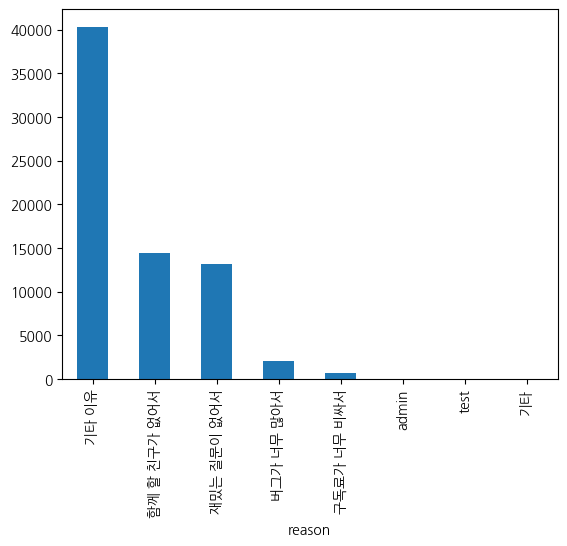

In [59]:
accounts_userwithdraw_df['reason'].value_counts().plot(kind = 'bar')
plt.show()

- 기타 이유를 제외하고는 '함께 할 친구가 없어서', '재밌는 질문이 없어서'가 상위를 차지함
- 그 다음에 '버그가 너무 많아서' 이유가 존재!!! -> 서비스 운영 상의 문제 

# 15. event_receipts : 포인트 이벤트 참여 테이블

In [240]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/event_receipts.parquet"
# 데이터 불러오기
event_receipts_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(event_receipts_df.head())
event_receipts_df.shape

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


(309, 5)

In [ ]:
event_receipts_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [ ]:
display(event_receipts_df.iloc[:,1:].duplicated().sum()) # 중복 x

# 중복 확인
event_receipts_df[event_receipts_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,created_at,event_id,user_id,plus_point


In [244]:
event_receipts_df.describe()

,id,created_at,event_id,user_id,plus_point
count,309.000000,309,309.000000,3.090000e+02,309.000000
mean,160.964401,2023-07-24 01:53:59.954692608,1.249191,1.179715e+06,559.870550
min,2.000000,2023-06-22 09:25:16,1.000000,8.378360e+05,500.000000
25%,82.000000,2023-07-10 16:58:20,1.000000,9.998160e+05,500.000000
50%,161.000000,2023-07-20 12:24:28,1.000000,1.139491e+06,500.000000
75%,239.000000,2023-07-29 09:38:22,1.000000,1.325911e+06,500.000000
max,321.000000,2023-11-21 12:03:02,3.000000,1.579064e+06,1000.000000
std,92.065029,NaN,0.563536,2.171981e+05,162.592579


- 2023-06-22 ~ 2023-11-21 데이터
- plus_point : 대부분 500 포인트짜리 이벤트?, 최대 1000포인트 이벤트 존재

In [245]:
# 년-월별 이벤트 건수 체크 
check_df = event_receipts_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-06     58
2023-07    194
2023-08     37
2023-09      2
2023-10      8
2023-11     10
Freq: M, Name: count, dtype: int64

- 23년 7월에 이벤트 가장 많았음      
-> 5월에 탈퇴가 많아서 이벤트로 붙잡으려고 했나?      
-> 아니면 그냥 일시적 이벤트가 좀 많았을지도

In [247]:
# 이벤트 아이디 
event_receipts_df['event_id'].unique()

array([1, 2, 3])

In [248]:
# 이벤트별 개수
event_receipts_df['event_id'].value_counts()

event_id
1    252
2     37
3     20
Name: count, dtype: int64

# 16. events : 포인트 이벤트 테이블

In [249]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/events.parquet"
# 데이터 불러오기
events_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(events_df.head())
events_df.shape

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


(3, 6)

# 17. polls_question : 질문 데이터 테이블

In [3]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/polls_question.parquet"
# 데이터 불러오기
polls_question_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_question_df.head())
polls_question_df.shape

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


(5025, 3)

In [126]:
polls_question_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             5025 non-null   int64         
 1   question_text  5025 non-null   object        
 2   created_at     5025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 117.9+ KB


In [15]:
display(polls_question_df.iloc[:,1:].duplicated().sum()) # 중복 34개

# 중복 확인
polls_question_df[polls_question_df.iloc[:,1:].duplicated(keep = False)]

np.int64(34)

,id,question_text,created_at
1542,1651,vote,2023-06-02 08:06:23
1543,1652,vote,2023-06-02 08:06:23
1544,1653,vote,2023-06-02 08:06:23
1545,1654,vote,2023-06-02 08:06:23
1546,1655,vote,2023-06-02 08:06:23
...,...,...,...
4241,4350,vote,2023-06-06 06:15:41
4438,4547,vote,2023-06-06 06:15:44
4440,4549,vote,2023-06-06 06:15:44
4787,4896,vote,2023-06-06 06:15:49


In [16]:
# 중복에 vote 말고 다른 것도 있는지 확인 
polls_question_df[polls_question_df.iloc[:,1:].duplicated(keep = False)]['question_text'].value_counts()

question_text
vote                      27
회사 비서에 잘 어울리는 사람           2
플래너 잘 쓸 것 같은 사람은?          2
집안일을 가장 잘 할 것 같은 사람은?      2
제일 마음씨 착할 것 같은 친구          2
잠버릇이 특이할 것 같은 친구           2
인스타 스토리가 웃긴 친구는?           2
이 학교의 퀸카는?                 2
연예인의 기질이 보이는 친구            2
선물을 주고 싶은 사람은?             2
생일때 단둘이 있고 싶은 사람           2
새해 첫날에 보고 싶은 친구는?          2
돈 관리 잘할 것 같은 친구            2
노래방에서 같이 춤 출 수 있는 친구는?     2
내가 전화하면 바로 달려올 것 같은 친구     2
나중에 대기업 사장이될 것 같은 사람       2
고백해본적 없을 것 같은 사람은?         2
가장 열심히 사는 것 같은 사람          2
Name: count, dtype: int64

In [252]:
polls_question_df.describe(include='all')

,id,question_text,created_at
count,5025.000000,5025,5025
unique,NaN,3903,NaN
top,NaN,vote,NaN
freq,NaN,56,NaN
mean,2619.897512,NaN,2023-05-26 17:49:11.666268672
min,99.000000,NaN,2023-03-31 15:22:53
25%,1365.000000,NaN,2023-05-15 14:03:03
50%,2621.000000,NaN,2023-06-02 08:06:53
75%,3877.000000,NaN,2023-06-06 06:10:14
max,5133.000000,NaN,2023-06-06 06:15:52


- 2023-03-31 ~ 2023-06-06 데이터
- question_text : vote가 가장 많음

In [129]:
# 질문 내용별 개수 
polls_question_df['question_text'].value_counts().reset_index()

,question_text,count
0,vote,56
1,눈이 제일 큰 사람은?,3
2,지금 뭐하는지 궁금한 친구,3
3,인생 2회차인 것 같은 사람은?,3
4,2세가 가장 귀여울 것 같은 사람은?,3
...,...,...
3898,조용한 매력이 있는 친구,1
3899,샤워 1시간 동안 할 것 같은 사람은?,1
3900,시간 약속을 제일 잘 지킬것 같은 사람은?,1
3901,너에게 칭찬을 받는다면 가장 기분 좋을 것 같아!,1


In [130]:
# 년-월별 질문 건수 체크 
check_df = polls_question_df.copy()
check_df['year_month'] = check_df['created_at'].dt.to_period('M')
check_df['year_month'].value_counts().sort_index()

year_month
2023-03      73
2023-04     154
2023-05    1309
2023-06    3489
Freq: M, Name: count, dtype: int64

- 갈수록 질문 건수 많아짐

# 18. polls_questionpiece : 질문 조각

In [4]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/polls_questionpiece.parquet"
# 데이터 불러오기
polls_questionpiece_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_questionpiece_df.head())
polls_questionpiece_df.shape

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


(1265476, 5)

In [103]:
polls_questionpiece_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265476 entries, 0 to 1265475
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1265476 non-null  int64         
 1   is_voted     1265476 non-null  int64         
 2   created_at   1265476 non-null  datetime64[ns]
 3   question_id  1265476 non-null  int64         
 4   is_skipped   1265476 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 48.3 MB


In [ ]:
display(polls_questionpiece_df.iloc[:,1:].duplicated().sum()) # 중복 572개

# 중복 확인
polls_questionpiece_df[polls_questionpiece_df.iloc[:,1:].duplicated(keep = False)]

np.int64(572)

,id,is_voted,created_at,question_id,is_skipped
19,998689,1,2023-04-28 12:28:38,247,0
33,998707,1,2023-04-28 12:28:38,247,0
707,1009124,1,2023-04-28 13:11:02,164,0
709,1009127,1,2023-04-28 13:11:02,119,0
710,1009132,1,2023-04-28 13:11:02,119,0
...,...,...,...,...,...
1123860,161754942,1,2023-05-28 14:38:10,407,0
1125308,162081958,1,2023-05-28 15:14:12,1476,0
1125314,162081994,1,2023-05-28 15:14:12,1476,0
1154452,169866193,1,2023-05-30 02:03:45,988,0


In [256]:
polls_questionpiece_df.describe()

,id,is_voted,created_at,question_id,is_skipped
count,1.265476e+06,1.265476e+06,1265476,1.265476e+06,1.265476e+06
mean,7.658001e+07,9.630266e-01,2023-05-17 13:39:58.427317504,7.133598e+02,8.905740e-04
min,9.984580e+05,0.000000e+00,2023-04-28 12:27:22,9.900000e+01,0.000000e+00
25%,2.029260e+07,1.000000e+00,2023-05-09 21:50:54,2.780000e+02,0.000000e+00
50%,6.846533e+07,1.000000e+00,2023-05-15 14:18:31.500000,4.770000e+02,0.000000e+00
75%,1.212662e+08,1.000000e+00,2023-05-22 09:56:44,9.820000e+02,0.000000e+00
max,2.083852e+08,1.000000e+00,2024-05-07 11:32:30,5.133000e+03,1.000000e+00
std,5.912924e+07,1.886967e-01,NaN,6.706815e+02,2.982921e-02


- 2023-04-28 ~ 2024-05-07 데이터
- is_votes : 투표 여부 1이 많음
- is_skipped : 대부분 0, 스킵을 안했다는 것?

# 19. polls_questionreport : 질문에 대한 신고기록 테이블

In [5]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/polls_questionreport.parquet"
# 데이터 불러오기
polls_questionreport_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_questionreport_df.head())
polls_questionreport_df.shape

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


(51424, 5)

In [132]:
polls_questionreport_df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51424 entries, 0 to 51423
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           51424 non-null  int64         
 1   reason       51424 non-null  object        
 2   created_at   51424 non-null  datetime64[ns]
 3   question_id  51424 non-null  int64         
 4   user_id      51424 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.0+ MB


In [ ]:
display(polls_questionreport_df.iloc[:,1:].duplicated().sum()) # 중복 x

# 중복 확인
polls_questionreport_df[polls_questionreport_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,reason,created_at,question_id,user_id


In [134]:
polls_questionreport_df.describe()

,id,created_at,question_id,user_id
count,51424.000000,51424,51424.000000,5.142400e+04
mean,28027.358587,2023-05-21 22:12:41.641120768,733.099098,1.168247e+06
min,1.000000,2023-04-19 06:20:35,99.000000,8.323400e+05
25%,14020.750000,2023-05-13 01:36:21.249999872,305.000000,9.784810e+05
50%,28047.500000,2023-05-18 14:33:45,494.000000,1.160251e+06
75%,42084.250000,2023-05-26 08:45:25,1021.000000,1.351295e+06
max,55767.000000,2024-05-05 14:56:25,5110.000000,1.583634e+06
std,16163.108294,NaN,666.021729,2.082471e+05


- 2023-05-21 ~ 2024-05-05 데이터 

In [135]:
# 신고 이유별 개수 
polls_questionreport_df['reason'].value_counts().reset_index()

,reason,count
0,그냥 싫어,28446
1,나랑 맞지 않는 질문인 것 같음,9541
2,불쾌한 질문 내용,5386
3,자꾸 같은 내용의 질문 반복,3202
4,어떻게 이런 생각을? 이 질문 최고!,1821
5,한 친구가 질문을 반복적으로 보냄,1701
6,기타,480
7,이 질문은 재미없어요,471
8,불쾌한 내용이 포함되어 있음,250
9,오타가 있음,68


- 그냥 싫어 가 1위..? 
- 불쾌한 내용, 같은 내용 반복 등의 이유도 상위권

# 20. polls_questionset : 질문 세트 테이블

In [6]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/polls_questionset.parquet"
# 데이터 불러오기
polls_questionset_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_questionset_df.head())
polls_questionset_df.shape

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


(158384, 6)

In [ ]:
polls_questionset_df.info() # 결측치 x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [261]:
display(polls_questionset_df.iloc[:,1:].duplicated().sum()) # 중복 x

# 중복 확인
polls_questionset_df[polls_questionset_df.iloc[:,1:].duplicated(keep = False)]

np.int64(0)

,id,question_piece_id_list,opening_time,status,created_at,user_id


In [262]:
polls_questionset_df.describe()

,id,opening_time,created_at,user_id
count,1.583840e+05,158384,158384,1.583840e+05
mean,7.641274e+06,2023-05-17 13:25:41.180416256,2023-05-17 12:43:12.170648832,1.106752e+06
min,9.981700e+04,2023-04-28 12:27:22,2023-04-28 12:27:23,8.380230e+05
25%,1.953393e+06,2023-05-09 15:46:49.500000,2023-05-09 14:58:05.500000,8.847470e+05
50%,6.757335e+06,2023-05-15 13:43:55.500000,2023-05-15 13:04:46.500000,1.117999e+06
75%,1.217510e+07,2023-05-22 11:43:24.500000,2023-05-22 11:04:03,1.261250e+06
max,2.083845e+07,2024-05-07 12:12:30,2024-05-07 11:32:30,1.583358e+06
std,5.943690e+06,NaN,NaN,2.078612e+05


- 2023-04-28 ~ 2024-05-07 데이터
- opening_time : 질문 오픈 시간 -> 시간대로 다시 보기

In [263]:
polls_questionset_df.describe(include = 'O')

,question_piece_id_list,status
count,158384,158384
unique,158384,3
top,"[208350161, 208350162, 208350163, 208350164, 2...",F
freq,1,153411


- status : 상태 F (종료) 가장 많음    
C 닫힘, O 열림, F 종료

In [19]:
# 질문 오픈 시간대 컬럼 추가
check_df = polls_questionset_df.copy()

check_df['open_hour'] = check_df['opening_time'].dt.hour

# 시간대별 개수
check_df['open_hour'].value_counts().sort_index()

open_hour
0      5157
1      4257
2      5009
3      5713
4      6040
5      6209
6      6540
7      7544
8      8719
9      9213
10     9391
11     9565
12    10907
13    12320
14    13085
15    12317
16     9156
17     5043
18     2112
19      847
20      422
21      558
22     2100
23     6160
Name: count, dtype: int64

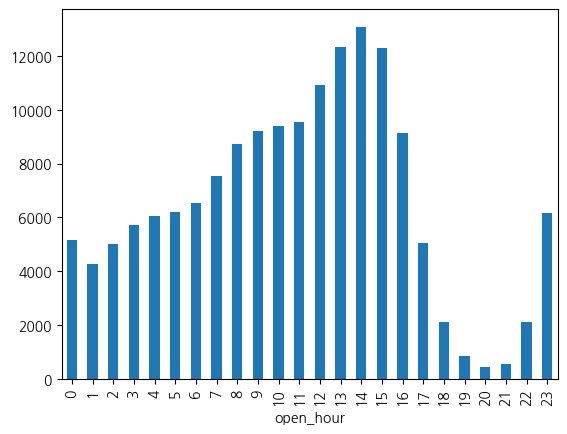

In [20]:
check_df['open_hour'].value_counts().sort_index().plot(kind = 'bar')
plt.show()

- 12시 ~ 15시에 가장 많이 질문 오픈됨
- 15시 이후에 급격히 감소
- 22시부터 살짝 증가하는 추세

In [ ]:
# question_piece_id_list 세트별로 질문 조각 몇개?

# question_piece_id_list 리스트로 변환
check_df['question_piece_id_list_transform'] = check_df['question_piece_id_list'].apply(ast.literal_eval)

# 질문 조각 갯수 컬럼 추가
check_df['question_piece_cnt'] = check_df['question_piece_id_list_transform'].apply(len)

check_df.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id,open_hour,question_piece_id_list_transform,question_piece_cnt
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,12,"[998458, 998459, 998460, 998461, 998462, 99846...",10
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438,12,"[998588, 998589, 998590, 998591, 998592, 99859...",10
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,12,"[998689, 998691, 998693, 998695, 998697, 99869...",10
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446,12,"[998688, 998690, 998692, 998694, 998696, 99869...",10
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477,12,"[998768, 998769, 998770, 998771, 998772, 99877...",10


In [ ]:
# 질문 세트마다 질문 조각이 몇개? 
check_df['question_piece_cnt'].value_counts()

question_piece_cnt
10    158384
Name: count, dtype: int64

# 21. polls_usercandidate : 질문 조각에 등장하는 유저들 테이블

In [7]:
# GCS 파일 경로
gcs_path = "gs://codeit-project/votes/polls_usercandidate.parquet"
# 데이터 불러오기
polls_usercandidate_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_usercandidate_df.head())
polls_usercandidate_df.shape

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


(4769609, 4)

In [270]:
polls_usercandidate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4769609 entries, 0 to 4769608
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         datetime64[ns]
 2   question_piece_id  int64         
 3   user_id            int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 145.6 MB


In [ ]:
polls_usercandidate_df.isnull().sum() # 결측치 없음

id                   0
created_at           0
question_piece_id    0
user_id              0
dtype: int64

In [ ]:
display(polls_usercandidate_df.iloc[:,1:].duplicated().sum()) # 중복 487개

# 중복 확인
polls_usercandidate_df[polls_usercandidate_df.iloc[:,1:].duplicated(keep = False)]

np.int64(487)

,id,created_at,question_piece_id,user_id
11814,3262907,2023-04-28 23:17:05,1035142,849977
11815,3262908,2023-04-28 23:17:05,1035142,850212
11816,3262909,2023-04-28 23:17:05,1035142,850215
11817,3262910,2023-04-28 23:17:05,1035142,850334
11818,3262911,2023-04-28 23:17:05,1035142,849977
...,...,...,...,...
4749819,641643522,2023-08-05 11:52:45,205599060,1285797
4749820,641643523,2023-08-05 11:52:45,205599060,953390
4749821,641643524,2023-08-05 11:52:45,205599060,991411
4749822,641643525,2023-08-05 11:52:45,205599060,1273168


In [273]:
polls_usercandidate_df.describe()

,id,created_at,question_piece_id,user_id
count,4.769609e+06,4769609,4.769609e+06,4.769609e+06
mean,2.388684e+08,2023-05-17 13:57:52.437731072,7.430248e+07,1.090241e+06
min,3.088872e+06,2023-04-28 12:27:49,9.984580e+05,8.331120e+05
25%,6.270339e+07,2023-05-10 02:49:19,1.891695e+07,8.835900e+05
50%,2.126700e+08,2023-05-15 16:15:12,6.639655e+07,1.087460e+06
75%,3.800215e+08,2023-05-22 11:33:33,1.178876e+08,1.233969e+06
max,6.466726e+08,2024-05-08 01:36:18,2.083515e+08,1.580629e+06
std,1.844893e+08,NaN,5.761959e+07,2.018190e+05


-  2023-04-28 ~ 2024-05-08 데이터

In [27]:
# id 컬럼 제외하고 중복제거 후 봐보기 
check_df = polls_usercandidate_df.drop_duplicates(subset=[col for col in polls_usercandidate_df.columns if col != 'id'])
display(check_df.shape)
check_df.head()

(4769122, 4)

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


In [28]:
# 유저별 등장한 question의 갯수 
check_df['user_id'].value_counts().describe()

count    19994.000000
mean       238.527658
std        447.287538
min          1.000000
25%          7.000000
50%         29.000000
75%        220.000000
max       4226.000000
Name: count, dtype: float64

- 유저마다 평균 238개의 질문에 등장
- 가장 많이 등장한 유저는 4226번 -> 인기쟁이 학생?

In [289]:
# 유저별 후보로 등장한 개수
check_df['user_id'].value_counts()

user_id
860304     4226
940572     4070
1137034    3948
1207066    3920
994573     3673
           ... 
931294        1
895301        1
1145289       1
1023019       1
1577398       1
Name: count, Length: 19994, dtype: int64

In [292]:
# 가장 많이 투표에 등장한 유저 확인
accounts_user_df[accounts_user_df['id'] == 860304]

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
17330,860304,0,0,F,1456,"[854016, 897024, 883202, 886787, 887299, 89241...",1,2023-04-30 14:00:55.219491,[],"[886265, 885202, 886552, 886853, 887060, 88820...",N,0,1,0,4,6875.0


In [297]:
# 가장 많이 등장한 유저의 학급
accounts_group_df[accounts_group_df['id'] == 6875]

,id,grade,class_num,school_id
6857,6875,1,8,352


In [298]:
# 가장 많이 등장한 유저의 학교
accounts_school_df[accounts_school_df['id'] == 352]

,id,address,student_count,school_type
348,352,충청남도 아산시,491,H


In [38]:
# 하나의 question_piece 질문 조각 마다 등장하는 후보 몇명?
piece_user_cnt_df = check_df.groupby(['question_piece_id','created_at']).size().reset_index(name = 'user_cnt')
piece_user_cnt_df.head()

piece_user_cnt_df['user_cnt'].value_counts()

user_cnt
4    1119169
3      95297
2       3164
1        227
Name: count, dtype: int64

- 하나의 질문 조각에 후보로 등록되는 유저의 수는 최대 4명 (이 경우가 가장 많음)

In [ ]:
# 질문 조각별 갯수 
check_df['question_piece_id'].value_counts()

question_piece_id
73172618     12
78049359      8
59677379      8
107912932     8
46888287      8
             ..
4586082       1
4331413       1
3836336       1
3483877       1
3266167       1
Name: count, Length: 1217589, dtype: int64

- 12명의 후보가 등록된 경우의 질문 조각이 존재?!

In [ ]:
# 후보 많은 질문 조각 확인
check_df[check_df['question_piece_id'] == 73172618]

,id,created_at,question_piece_id,user_id
2558530,233629748,2023-05-16 12:41:49,73172618,1136747
2558531,233629749,2023-05-16 12:41:49,73172618,1137886
2558532,233629750,2023-05-16 12:41:49,73172618,1138409
2558533,233629751,2023-05-16 12:41:49,73172618,1155307
2558534,233630440,2023-05-16 12:41:59,73172618,1136747
2558535,233630441,2023-05-16 12:41:59,73172618,1137886
2558536,233630442,2023-05-16 12:41:59,73172618,1138409
2558537,233630443,2023-05-16 12:41:59,73172618,1155307
2558538,233632168,2023-05-16 12:42:05,73172618,1136747
2558539,233632169,2023-05-16 12:42:05,73172618,1137886


- 모두 생성일시 기준으로 보면 후보 4명씩임!

# (id 확인1) question의 id == questionpiece 의 question_id ?? 

In [149]:
def check_id(df1, df2, left_on, right_on, how1, how2, df1_name='df1', df2_name='df2'):
    
    # 형태확인
    print(f'\n [{df1_name}] 미리보기')
    display(df1.head())
    print(f'\n [{df2_name}] 미리보기')
    display(df2.head())
    
    # 질문 조각의 question_id로 이 질문의 내용이 어떤 것이었는지 알아낼 수 있나? 
    # merge 해서 보기
    # df1 테이블 기준 병합 
    merged_df1_df2 = pd.merge(df1, df2, left_on = left_on, right_on = right_on, how = how1)
    print(f'\n [{df1_name}] 기준 "{how1}" 조인 결과')
    display(merged_df1_df2.head())

    # df2 테이블 기준 병합
    merged_df2_df1 = pd.merge(df1, df2, left_on = left_on, right_on = right_on, how = how2)
    print(f'\n [{df2_name}] 기준 "{how2}" 조인 결과')
    display(merged_df2_df1.head())
    
    # null 개수 확인
    print(f'\n [{df1_name}] 기준 "{how1}" 조인 후 NULL 개수:')
    null_counts1 = merged_df1_df2.isnull().sum()
    display(null_counts1)

    print(f'\n [{df2_name}] 기준 "{how2}" 조인 후 NULL 개수:')
    null_counts2 = merged_df2_df1.isnull().sum()
    display(null_counts2)

    # null이 있는 컬럼만 필터링해서 해당 행 출력
    if null_counts1.sum() > 0:
        print(f'\n [{df1_name}] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):')
        cols_with_null_1 = null_counts1[null_counts1 > 0].index
        display(merged_df1_df2[merged_df1_df2[cols_with_null_1].isnull().any(axis=1)].head())

    if null_counts2.sum() > 0:
        print(f'\n [{df2_name}] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):')
        cols_with_null_2 = null_counts2[null_counts2 > 0].index
        display(merged_df2_df1[merged_df2_df1[cols_with_null_2].isnull().any(axis=1)].head())
        
    # 병합 결과 리턴
    return merged_df1_df2, merged_df2_df1

In [150]:
left_df, right_df = check_id(
    polls_question_df,
    polls_questionpiece_df,
    left_on='id',
    right_on='question_id',
    how1='left',
    how2='right',
    df1_name='polls_question_df',
    df2_name='polls_questionpiece_df'
); # 리턴하는 건 left_df, right_df에 저장만 하고 출력 안하도록 세미콜론! 


 [polls_question_df] 미리보기


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55



 [polls_questionpiece_df] 미리보기


,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0



 [polls_question_df] 기준 "left" 조인 결과


,id_x,question_text,created_at_x,id_y,is_voted,created_at_y,question_id,is_skipped
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,998700.0,1.0,2023-04-28 12:28:38,99.0,0.0
1,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,999008.0,1.0,2023-04-28 12:30:14,99.0,0.0
2,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,999265.0,1.0,2023-04-28 12:31:19,99.0,0.0
3,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,1013583.0,1.0,2023-04-28 13:32:32,99.0,0.0
4,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,1022050.0,1.0,2023-04-28 14:12:23,99.0,0.0



 [polls_questionpiece_df] 기준 "right" 조인 결과


,id_x,question_text,created_at_x,id_y,is_voted,created_at_y,question_id,is_skipped
0,252,손이 가장 이쁘게 생겼을거 같은 사람은?,2023-04-01 11:09:27,998458,1,2023-04-28 12:27:22,252,0
1,244,대학교에서 학생회장할 것 같은 사람은?,2023-04-01 11:09:26,998459,1,2023-04-28 12:27:22,244,0
2,183,나의 자존감을 가장 많이 높여줬던 사람은?,2023-04-01 11:09:14,998460,1,2023-04-28 12:27:22,183,0
3,101,미래의 틱톡커는?,2023-03-31 15:22:54,998461,1,2023-04-28 12:27:22,101,0
4,209,항상 좋은 냄새가 나는 사람은?,2023-04-01 11:09:20,998462,1,2023-04-28 12:27:22,209,0



 [polls_question_df] 기준 "left" 조인 후 NULL 개수:


id_x              0
question_text     0
created_at_x      0
id_y             81
is_voted         81
created_at_y     81
question_id      81
is_skipped       81
dtype: int64


 [polls_questionpiece_df] 기준 "right" 조인 후 NULL 개수:


id_x             0
question_text    0
created_at_x     0
id_y             0
is_voted         0
created_at_y     0
question_id      0
is_skipped       0
dtype: int64


 [polls_question_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,question_text,created_at_x,id_y,is_voted,created_at_y,question_id,is_skipped
1262949,4162,모기를 가장 잘 물릴 것 같은 사람은?,2023-06-06 06:15:39,NaN,NaN,NaT,NaN,NaN
1262959,4166,취미 되게 다양할 것 같은 친구,2023-06-06 06:15:39,NaN,NaN,NaT,NaN,NaN
1262972,4170,집에 혼자 있으면 무섭다고 전화할 것 같은 친구는?,2023-06-06 06:15:39,NaN,NaN,NaT,NaN,NaN
1262989,4176,공부 제일 잘 알려줄 것 같은 사람,2023-06-06 06:15:39,NaN,NaN,NaT,NaN,NaN
1262999,4180,함께 별보러 가고 싶은 사람,2023-06-06 06:15:39,NaN,NaN,NaT,NaN,NaN


**결론?**      
questionpiece의 question_id는 모두 question에 있음!!       
question 테이블의 id == questionpiece 테이블의 question_id 

# (id 확인2) question의 id == questionreport 의 question_id ?? 

In [151]:
left_df, right_df  = check_id(
    polls_question_df,
    polls_questionreport_df,
    left_on='id',
    right_on='question_id',
    how1='left',
    how2='right',
    df1_name='polls_question_df',
    df2_name='polls_questionreport_df'
);


 [polls_question_df] 미리보기


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55



 [polls_questionreport_df] 미리보기


,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922



 [polls_question_df] 기준 "left" 조인 결과


,id_x,question_text,created_at_x,id_y,reason,created_at_y,question_id,user_id
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,279.0,이 질문은 재미없어요,2023-04-22 18:27:58,99.0,839056.0
1,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,684.0,어떻게 이런 생각을? 이 질문 최고!,2023-04-26 10:39:03,99.0,846015.0
2,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,902.0,어떻게 이런 생각을? 이 질문 최고!,2023-04-28 18:07:27,99.0,847472.0
3,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,914.0,어떻게 이런 생각을? 이 질문 최고!,2023-04-29 01:54:40,99.0,849845.0
4,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,1053.0,어떻게 이런 생각을? 이 질문 최고!,2023-04-29 12:40:03,99.0,851144.0



 [polls_questionreport_df] 기준 "right" 조인 결과


,id_x,question_text,created_at_x,id_y,reason,created_at_y,question_id,user_id
0,250,와이드한 느낌이 잘 어울리는 사람은?,2023-04-01 11:09:27,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,113,첫인상과 아예 반대라고 느낀 사람은?,2023-03-31 15:23:00,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,113,첫인상과 아예 반대라고 느낀 사람은?,2023-03-31 15:23:00,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,119,시간 약속을 제일 잘 지킬것 같은 사람은?,2023-03-31 15:23:02,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,119,시간 약속을 제일 잘 지킬것 같은 사람은?,2023-03-31 15:23:02,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922



 [polls_question_df] 기준 "left" 조인 후 NULL 개수:


id_x                0
question_text       0
created_at_x        0
id_y             1890
reason           1890
created_at_y     1890
question_id      1890
user_id          1890
dtype: int64


 [polls_questionreport_df] 기준 "right" 조인 후 NULL 개수:


id_x             0
question_text    0
created_at_x     0
id_y             0
reason           0
created_at_y     0
question_id      0
user_id          0
dtype: int64


 [polls_question_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,question_text,created_at_x,id_y,reason,created_at_y,question_id,user_id
48772,1647,MBTI 잘 믿을 것 같은 사람은?,2023-06-02 08:06:23,NaN,NaN,NaT,NaN,NaN
48782,1650,mbti에서 E를 대표하는 사람은?,2023-06-02 08:06:23,NaN,NaN,NaT,NaN,NaN
48783,1651,vote,2023-06-02 08:06:23,NaN,NaN,NaT,NaN,NaN
48793,1656,vote,2023-06-02 08:06:23,NaN,NaN,NaT,NaN,NaN
48802,1660,힘내라고 해주고 싶은 친구,2023-06-02 08:06:23,NaN,NaN,NaT,NaN,NaN


**결론?**      
questionreport의 question_id는 모두 question에 있음!!       
question 테이블의 id == questionreport의 테이블의 question_id 

# (id 확인3) questionpiece의 id == usercandidate 의 question_piece_id ?? 

In [73]:
polls_questionset_df.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


In [152]:
left_df, right_df = check_id(
    polls_questionpiece_df,
    polls_usercandidate_df,
    left_on='id',
    right_on='question_piece_id',
    how1='left',
    how2='right',
    df1_name='polls_questionpiece_df',
    df2_name='polls_usercandidate_df'
);


 [polls_questionpiece_df] 미리보기


,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0



 [polls_usercandidate_df] 미리보기


,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446



 [polls_questionpiece_df] 기준 "left" 조인 결과


,id_x,is_voted,created_at_x,question_id,is_skipped,id_y,created_at_y,question_piece_id,user_id
0,998458,1,2023-04-28 12:27:22,252,0,3088872.0,2023-04-28 12:27:49,998458.0,849444.0
1,998458,1,2023-04-28 12:27:22,252,0,3088873.0,2023-04-28 12:27:49,998458.0,849454.0
2,998458,1,2023-04-28 12:27:22,252,0,3088874.0,2023-04-28 12:27:49,998458.0,849460.0
3,998458,1,2023-04-28 12:27:22,252,0,3088875.0,2023-04-28 12:27:49,998458.0,849469.0
4,998459,1,2023-04-28 12:27:22,244,0,3088964.0,2023-04-28 12:28:02,998459.0,849446.0



 [polls_usercandidate_df] 기준 "right" 조인 결과


,id_x,is_voted,created_at_x,question_id,is_skipped,id_y,created_at_y,question_piece_id,user_id
0,998458,1,2023-04-28 12:27:22,252,0,3088872,2023-04-28 12:27:49,998458,849444
1,998458,1,2023-04-28 12:27:22,252,0,3088873,2023-04-28 12:27:49,998458,849454
2,998458,1,2023-04-28 12:27:22,252,0,3088874,2023-04-28 12:27:49,998458,849460
3,998458,1,2023-04-28 12:27:22,252,0,3088875,2023-04-28 12:27:49,998458,849469
4,998459,1,2023-04-28 12:27:22,244,0,3088964,2023-04-28 12:28:02,998459,849446



 [polls_questionpiece_df] 기준 "left" 조인 후 NULL 개수:


id_x                     0
is_voted                 0
created_at_x             0
question_id              0
is_skipped               0
id_y                 47887
created_at_y         47887
question_piece_id    47887
user_id              47887
dtype: int64


 [polls_usercandidate_df] 기준 "right" 조인 후 NULL 개수:


id_x                 0
is_voted             0
created_at_x         0
question_id          0
is_skipped           0
id_y                 0
created_at_y         0
question_piece_id    0
user_id              0
dtype: int64


 [polls_questionpiece_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,is_voted,created_at_x,question_id,is_skipped,id_y,created_at_y,question_piece_id,user_id
4155,1015518,0,2023-04-28 13:41:27,268,0,NaN,NaT,NaN,NaN
4156,1015519,0,2023-04-28 13:41:27,184,0,NaN,NaT,NaN,NaN
4157,1015520,0,2023-04-28 13:41:27,141,0,NaN,NaT,NaN,NaN
4158,1015521,0,2023-04-28 13:41:27,172,0,NaN,NaT,NaN,NaN
4159,1015522,0,2023-04-28 13:41:27,259,0,NaN,NaT,NaN,NaN


**결론?**      
usercandidate의 question_piece_id는 모두 questionpiece에 있음!!       
questionpiece 테이블의 id == usercandidate의 테이블의 question_piece_id

# (id 확인4) group의 school_id와 school의 id

In [ ]:
# group의 school_id 와 school의 id 고유값 개수 
print(accounts_group_df['school_id'].nunique())
print(accounts_school_df['id'].nunique())

5604
5951


In [114]:
# group_id와 id의 범위 확인 
print('group 테이블의 school_id describe 결과')
display(accounts_group_df['school_id'].describe())
print('school 테이블의 id describe 결과')
display(accounts_school_df['id'].describe(include='all'))

group 테이블의 school_id describe 결과


count    84515.000000
mean      3079.496468
std       1675.036093
min          1.000000
25%       1752.000000
50%       3023.000000
75%       4620.000000
max       5965.000000
Name: school_id, dtype: float64

school 테이블의 id describe 결과


count    5951.000000
mean     2981.026046
std      1719.084020
min         4.000000
25%      1493.500000
50%      2981.000000
75%      4469.500000
max      5965.000000
Name: id, dtype: float64

In [153]:
left_df, right_df = check_id(
    accounts_group_df,
    accounts_school_df,
    left_on='school_id',
    right_on='id',
    how1='left',
    how2='right',
    df1_name='accounts_group_df',
    df2_name='accounts_school_df'
);


 [accounts_group_df] 미리보기


,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1



 [accounts_school_df] 미리보기


,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M



 [accounts_group_df] 기준 "left" 조인 결과


,id_x,grade,class_num,school_id,id_y,address,student_count,school_type
0,1,1,1,1,NaN,NaN,NaN,NaN
1,8,3,2,1,NaN,NaN,NaN,NaN
2,9,3,3,1,NaN,NaN,NaN,NaN
3,10,2,2,1,NaN,NaN,NaN,NaN
4,11,2,3,1,NaN,NaN,NaN,NaN



 [accounts_school_df] 기준 "right" 조인 결과


,id_x,grade,class_num,school_id,id_y,address,student_count,school_type
0,2721.0,2.0,5.0,4.0,4,충청북도 충주시,239,H
1,5361.0,3.0,3.0,4.0,4,충청북도 충주시,239,H
2,9733.0,1.0,5.0,4.0,4,충청북도 충주시,239,H
3,25791.0,2.0,6.0,4.0,4,충청북도 충주시,239,H
4,40966.0,3.0,4.0,4.0,4,충청북도 충주시,239,H



 [accounts_group_df] 기준 "left" 조인 후 NULL 개수:


id_x              0
grade             0
class_num         0
school_id         0
id_y             26
address          26
student_count    26
school_type      26
dtype: int64


 [accounts_school_df] 기준 "right" 조인 후 NULL 개수:


id_x             348
grade            348
class_num        348
school_id        348
id_y               0
address            0
student_count      0
school_type        0
dtype: int64


 [accounts_group_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,grade,class_num,school_id,id_y,address,student_count,school_type
0,1,1,1,1,NaN,NaN,NaN,NaN
1,8,3,2,1,NaN,NaN,NaN,NaN
2,9,3,3,1,NaN,NaN,NaN,NaN
3,10,2,2,1,NaN,NaN,NaN,NaN
4,11,2,3,1,NaN,NaN,NaN,NaN



 [accounts_school_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,grade,class_num,school_id,id_y,address,student_count,school_type
251,NaN,NaN,NaN,NaN,21,충청북도 충주시,0,M
285,NaN,NaN,NaN,NaN,26,충청북도 충주시,0,H
374,NaN,NaN,NaN,NaN,35,충청북도 충주시,0,H
690,NaN,NaN,NaN,NaN,53,충청북도 청주시 흥덕구,0,H
1460,NaN,NaN,NaN,NaN,96,충청북도 청주시 서원구,0,H


In [ ]:
# group에는 있는데 school에는 없는 id
left_df[left_df.isnull().any(axis=1)]['school_id'].value_counts()

school_id
1    26
Name: count, dtype: int64

In [141]:
# school에는 있는데 group에는 없는 id
right_df[right_df.isnull().any(axis=1)]['id_y'].value_counts()

id_y
5954    1
21      1
26      1
35      1
53      1
       ..
221     1
220     1
208     1
203     1
165     1
Name: count, Length: 348, dtype: int64

- school 테이블에 없는 id 인데, group 테이블의 school_id에 '1' 이 존재 
- school 테이블에 정보가 있지만, group 테이블에 있는 school_id와 매치되지 않는 것 348개 존재

# (id 확인5) pointhistory 테이블의 user_question_record_id == userquestionrecord 테이블의 id ?

In [118]:
display(accounts_pointhistory_df['user_question_record_id'].describe())
display(accounts_userquestionrecord_df['id'].describe())

count    2.335926e+06
mean     6.141803e+07
std      4.531970e+07
min      7.717770e+05
25%      2.088561e+07
50%      5.540614e+07
75%      9.555855e+07
max      1.616665e+08
Name: user_question_record_id, dtype: float64

count    1.217558e+06
mean     5.957298e+07
std      4.608193e+07
min      7.717770e+05
25%      1.553965e+07
50%      5.302680e+07
75%      9.480960e+07
max      1.616665e+08
Name: id, dtype: float64

In [154]:
left_df, right_df = check_id(
    accounts_pointhistory_df,
    accounts_userquestionrecord_df,
    left_on='user_question_record_id',
    right_on='id',
    how1='left',
    how2='right',
    df1_name='accounts_pointhistory_df',
    df2_name='accounts_userquestionrecord_df'
);


 [accounts_pointhistory_df] 미리보기


,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0



 [accounts_userquestionrecord_df] 미리보기


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0



 [accounts_pointhistory_df] 기준 "left" 조인 결과


,id_x,delta_point,created_at_x,user_id_x,user_question_record_id,id_y,status,created_at_y,chosen_user_id,question_id,user_id_y,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,790629,9,2023-04-28 12:27:49,849436,771777.0,771777.0,C,2023-04-28 12:27:49,849469.0,252.0,849436.0,998458.0,0.0,N,2023-04-28 12:27:49,0.0,0.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0,771800.0,C,2023-04-28 12:28:02,849446.0,244.0,849436.0,998459.0,0.0,N,2023-04-28 12:28:02,0.0,0.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0,771812.0,C,2023-04-28 12:28:09,849454.0,183.0,849436.0,998460.0,1.0,N,2023-04-28 12:28:09,0.0,0.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0,771828.0,C,2023-04-28 12:28:16,847375.0,101.0,849436.0,998461.0,0.0,N,2023-04-28 12:28:16,0.0,0.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0,771851.0,C,2023-04-28 12:28:26,849477.0,209.0,849436.0,998462.0,1.0,N,2023-04-28 12:28:26,0.0,0.0



 [accounts_userquestionrecord_df] 기준 "right" 조인 결과


,id_x,delta_point,created_at_x,user_id_x,user_question_record_id,id_y,status,created_at_y,chosen_user_id,question_id,user_id_y,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,790629.0,9.0,2023-04-28 12:27:49,849436.0,771777.0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,790652.0,9.0,2023-04-28 12:28:02,849436.0,771800.0,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,790664.0,5.0,2023-04-28 12:28:09,849436.0,771812.0,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,790680.0,13.0,2023-04-28 12:28:16,849436.0,771828.0,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,790703.0,5.0,2023-04-28 12:28:26,849436.0,771851.0,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0



 [accounts_pointhistory_df] 기준 "left" 조인 후 NULL 개수:


id_x                          0
delta_point                   0
created_at_x                  0
user_id_x                     0
user_question_record_id    2992
id_y                       2992
status                     2992
created_at_y               2992
chosen_user_id             2992
question_id                2992
user_id_y                  2992
question_piece_id          2992
has_read                   2992
answer_status              2992
answer_updated_at          2992
report_count               2992
opened_times               2992
dtype: int64


 [accounts_userquestionrecord_df] 기준 "right" 조인 후 NULL 개수:


id_x                       4
delta_point                4
created_at_x               4
user_id_x                  4
user_question_record_id    4
id_y                       0
status                     0
created_at_y               0
chosen_user_id             0
question_id                0
user_id_y                  0
question_piece_id          0
has_read                   0
answer_status              0
answer_updated_at          0
report_count               0
opened_times               0
dtype: int64


 [accounts_pointhistory_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,delta_point,created_at_x,user_id_x,user_question_record_id,id_y,status,created_at_y,chosen_user_id,question_id,user_id_y,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
2309070,330683383,200,2023-06-22 09:01:32,1219402,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2309385,330788563,200,2023-06-22 11:55:43,1120688,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2310273,331188040,200,2023-06-23 13:03:45,927655,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2310274,331188140,500,2023-06-23 13:03:58,927655,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2310275,331188257,1000,2023-06-23 13:04:11,927655,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN



 [accounts_userquestionrecord_df] 기준 조인 결과에서 NULL 포함된 행 (상위 5개):


,id_x,delta_point,created_at_x,user_id_x,user_question_record_id,id_y,status,created_at_y,chosen_user_id,question_id,user_id_y,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
2026045,NaN,NaN,NaT,NaN,NaN,120980026,C,2023-05-27 14:24:03,887050,1226,886111,148140791,0,N,2023-05-27 14:24:03,0,0
2026050,NaN,NaN,NaT,NaN,NaN,120980190,C,2023-05-27 14:24:12,1119693,346,1001610,153417374,1,N,2023-05-27 14:24:12,0,0
2027249,NaN,NaN,NaT,NaN,NaN,121108950,C,2023-05-27 14:52:09,1498168,534,1404671,153759320,1,N,2023-05-27 14:52:09,0,0
2027252,NaN,NaN,NaT,NaN,NaN,121109094,C,2023-05-27 14:52:09,1065317,372,917557,154481645,1,N,2023-05-27 14:52:09,0,0


In [ ]:
# pointhistory에는 있는데 userquestionrecord에는 없는 id
left_df[left_df.isnull().any(axis=1)]['user_question_record_id'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
# userquestionrecord에는 있는데 pointhistory에는 없는 id
right_df[right_df.isnull().any(axis=1)]['id_y'].value_counts()

id_y
120980026    1
120980190    1
121108950    1
121109094    1
Name: count, dtype: int64

# (테이블 추가확인) 20번 테이블 파헤치기

18. polls_questionpiece의 문제
투표 안 되고 스킵이 안 된 경우

1. 비정상적인 종료
    1. 10개 투표중 한 4번째에서 종료 → 그럼 나머지도 모두 저런식으로 처리되는것인가?
    2. 종료를 했으면 그 세트는 끝인가? 아님 다시 연달아 가능?       
=> is_skipped, is_voted가 모두 0인 경우 중 4만건 : 신고한 경우

20.polls_questionset의 문제

1. created_at 과 opening_time 의미에 대해 생각해보기    
1-1. 만든시간과 질문 오픈시간 존재
    - 그렇다면 미리 만들고 특정시간에 오픈을 하는가? 아니면 질문 조각 중 랜덤으로 하나씩 초이스되어 10개가 되는 것인가? 
3. status가 c 닫힘, o 열림, f 종료 3가지인데, c 닫힘은 10개를 다 채우지 못하고 중간에 닫은 경우인가?
    - 18번 테이블의 is_skipped, is_voted가 모두 0인 경우를 이와 연계해서 해결할 수 있을까?


## opening_time 과 created_at의 의미

In [ ]:
# opening_time 과 created_at의 의미
## 명세서에 따르면, questionset 테이블은 "유저가 질문 한 세트에 대한 답변을 끝낼때 생성되는 데이터."
## 그렇다면? opening_time 질문 오픈 시간 / created_at 만든 시간 중 만든 시간이 더 뒤에 와야하는 것?!


# opening_time과 created_at의 차이 컬럼 추가 
polls_questionset_df['time_diff'] = polls_questionset_df['created_at'] - polls_questionset_df['opening_time']

# 시간 차이 통계량
display(polls_questionset_df['time_diff'].describe())


count                         158384
mean     -1 days +23:17:30.990232600
std        0 days 02:16:39.060397276
min               -36 days +16:17:03
25%                -1 days +23:10:00
50%                -1 days +23:20:00
75%                -1 days +23:20:00
max                  0 days 00:00:29
Name: time_diff, dtype: object

In [ ]:
# 차이가 음수인 경우 (created_at 이 opening_time보다 앞선 경우)
polls_questionset_df[polls_questionset_df['time_diff'].dt.total_seconds() < 0]

,id,question_piece_id_list,opening_time,status,created_at,user_id,time_diff
7,99863,"[998918, 998919, 998920, 998921, 998922, 99892...",2023-04-28 12:32:16,F,2023-04-28 12:29:34,849436,-1 days +23:57:18
12,99880,"[999088, 999089, 999090, 999091, 999092, 99909...",2023-04-28 13:20:35,F,2023-04-28 12:30:35,847375,-1 days +23:10:00
16,99892,"[999208, 999209, 999210, 999211, 999212, 99921...",2023-04-28 13:21:10,F,2023-04-28 12:31:10,849479,-1 days +23:10:00
17,99897,"[999258, 999259, 999260, 999261, 999262, 99926...",2023-04-28 13:21:19,F,2023-04-28 12:31:19,849438,-1 days +23:10:00
20,99914,"[999428, 999429, 999430, 999431, 999432, 99943...",2023-04-28 13:21:44,F,2023-04-28 12:31:44,849452,-1 days +23:10:00
...,...,...,...,...,...,...,...
158379,20838253,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933,-1 days +23:20:00
158380,20838344,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072,-1 days +23:20:00
158381,20838419,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878,-1 days +23:20:00
158382,20838445,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607,-1 days +23:20:00


- questionset의  created_at (만든 시간) 이 opening_time (질문 오픈 시간) 보다 더 빠른 시간대인 경우가 152667행으로 전체의 약 96.4% 

In [87]:
# 차이가 0 or 양수인 경우 (created_at 이 opening_time와 동일하거나 느린 경우)
display(polls_questionset_df[polls_questionset_df['time_diff'].dt.total_seconds() == 0].shape)
display(polls_questionset_df[polls_questionset_df['time_diff'].dt.total_seconds() > 0].shape)

(5038, 7)

(679, 7)

- opening_time (질문 오픈 시간) == created_at (만든 시간) 인 경우 5038행, 전체의 약 3.2%
- opening_time (질문 오픈 시간) < created_at (만든 시간) 인 경우 679행, 전체의 약 0.4%

In [88]:
# created_at이 opening_time보다 느릴 때 시간 차이의 통계량
polls_questionset_df[polls_questionset_df['time_diff'].dt.total_seconds() > 0]['time_diff'].describe()

count                          679
mean     0 days 00:00:01.378497790
std      0 days 00:00:01.923970079
min                0 days 00:00:01
25%                0 days 00:00:01
50%                0 days 00:00:01
75%                0 days 00:00:01
max                0 days 00:00:29
Name: time_diff, dtype: object

- created_at (만든 시간)이 opening_time (질문 오픈 시간)보다 늦을 때, 보통 1초 차이로 늦고, 최대 29초 차이인 경우도 있었음

**종합**

- created_at (만든 시간) 이 opening_time (질문 오픈 시간) 보다 빠른 경우가 우세함(약 96.4%)  
- 동일 시간인 경우는 약 3.2%
- **만든 시간**이 **질문 오픈 시간**보다 느린 경우는 거의 대부분 1초 차이로 느린 경우! (최대 29초 느림)      
-> 미리 질문 세트가 10개씩 만들어져 있고 (세트가 만들어진 시간 = created_at?), 그걸 유저가 오픈하면 (이게 opening_time?)

## status c(닫힘)의 의미?

In [8]:

# status c(닫힘)의 의미?
## question_piece_id_list에서 question_piece_id 모두 추출하기

questionset_df_copy = polls_questionset_df.copy() # 카피해서 적용하기


# 1. 문자열 리스트를 진짜 리스트로 변환
questionset_df_copy['question_piece_id_list'] = questionset_df_copy['question_piece_id_list'].apply(ast.literal_eval)

# 2. 리스트를 새 컬럼으로 복사 (새 컬럼은 리스트 펼치고, 기존 question_piece_id_list는 그대로 남기기 위해서!)
questionset_df_copy['question_piece_id'] = questionset_df_copy['question_piece_id_list']

# 3. question_piece_id 컬럼을 explode
questionset_df_exploded = questionset_df_copy.explode('question_piece_id')

# 4. question_piece_id를 정수형으로 변환
questionset_df_exploded['question_piece_id'] = questionset_df_exploded['question_piece_id'].astype(int)

# 결과 확인
display(questionset_df_exploded.shape)
questionset_df_exploded.head(20)

(1583840, 7)

,id,question_piece_id_list,opening_time,status,created_at,user_id,question_piece_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998458
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998459
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998460
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998461
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998462
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998463
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998464
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998465
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998466
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436,998467


In [ ]:
# question_id 숫자가 연속적? -> 차이가 모두 9일까 확인
# id별로 최댓값과 최솟값의 차이 계산
diff_df = questionset_df_exploded.groupby('id')['question_piece_id'].agg(['min', 'max'])
diff_df['diff'] = diff_df['max'] - diff_df['min']

# 차이가 9인지 확인
diff_check = diff_df['diff'] == 9

# 결과 요약
print(f"전체 id 수: {len(diff_df)}")
print(f"차이가 9인 id 수: {diff_check.sum()}")
print(f"차이가 9가 아닌 id 예시:\n{diff_df[~diff_check].head()}")


전체 id 수: 158384
차이가 9인 id 수: 52738
차이가 9가 아닌 id 예시:
            min      max  diff
id                            
99840    998689   998706    17
99841    998688   998707    19
99852    998808   998821    13
100054  1000828  1000839    11
100444  1004727  1004737    10


In [ ]:
# 샘플 확인 -> 중간에 없는 숫자는?
questionset_df_exploded[questionset_df_exploded['id'] == 99840]

,id,question_piece_id_list,opening_time,status,created_at,user_id,time_diff,question_piece_id
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998689
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998691
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998693
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998695
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998697
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998699
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998700
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998702
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998704
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375,0 days,998706


In [129]:
polls_questionpiece_df[polls_questionpiece_df['id'].isin([998690,998692,998694,998696,998701,998703,998705])] # piece_id가 있는데두 안나오는 경우도 존재..;;

,id,is_voted,created_at,question_id,is_skipped
22,998694,1,2023-04-28 12:28:38,205,0
24,998696,1,2023-04-28 12:28:38,251,0
28,998701,1,2023-04-28 12:28:38,189,0
30,998703,1,2023-04-28 12:28:38,291,0


In [171]:
questionset_df_exploded[questionset_df_exploded['question_piece_id'].isin([998694,998696,998701,998703])]

,id,question_piece_id_list,opening_time,status,created_at,user_id,time_diff,question_piece_id
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446,0 days,998694
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446,0 days,998696
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446,0 days,998701
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446,0 days,998703


In [13]:
polls_questionpiece_df.shape

(1265476, 5)

In [9]:
# questionpiece 테이블 기준 left 조인
merged_question_piece_set = pd.merge(
    polls_questionpiece_df, \
    questionset_df_exploded[['id','user_id','question_piece_id','created_at','opening_time','status']], \
    left_on = 'id',\
    right_on = 'question_piece_id',\
    how = 'left')

merged_question_piece_set = merged_question_piece_set.rename(columns = {'id_y':'set_id'})
display(merged_question_piece_set.shape)
merged_question_piece_set.head()

(1265476, 11)

,id_x,is_voted,created_at_x,question_id,is_skipped,set_id,user_id,question_piece_id,created_at_y,opening_time,status
0,998458,1,2023-04-28 12:27:22,252,0,99817,849436,998458,2023-04-28 12:27:23,2023-04-28 12:27:22,F
1,998459,1,2023-04-28 12:27:22,244,0,99817,849436,998459,2023-04-28 12:27:23,2023-04-28 12:27:22,F
2,998460,1,2023-04-28 12:27:22,183,0,99817,849436,998460,2023-04-28 12:27:23,2023-04-28 12:27:22,F
3,998461,1,2023-04-28 12:27:22,101,0,99817,849436,998461,2023-04-28 12:27:23,2023-04-28 12:27:22,F
4,998462,1,2023-04-28 12:27:22,209,0,99817,849436,998462,2023-04-28 12:27:23,2023-04-28 12:27:22,F


In [10]:
merged_question_piece_set.isnull().sum() # question_piece에 있는 id는 모두 question_set에 piece로 들어가있음 

id_x                 0
is_voted             0
created_at_x         0
question_id          0
is_skipped           0
set_id               0
user_id              0
question_piece_id    0
created_at_y         0
opening_time         0
status               0
dtype: int64

In [11]:
# question_set 테이블 기준 left 조인 
merged_question_set_piece = pd.merge(
    questionset_df_exploded[['id','user_id','question_piece_id','created_at','opening_time','status']], \
    polls_questionpiece_df, \
    left_on = 'question_piece_id',\
    right_on = 'id',\
    how = 'left')

merged_question_set_piece = merged_question_set_piece.rename(columns = {'id_x':'set_id'})
display(merged_question_set_piece.shape)
merged_question_set_piece.head()

(1583840, 11)

,set_id,user_id,question_piece_id,created_at_x,opening_time,status,id_y,is_voted,created_at_y,question_id,is_skipped
0,99817,849436,998458,2023-04-28 12:27:23,2023-04-28 12:27:22,F,998458.0,1.0,2023-04-28 12:27:22,252.0,0.0
1,99817,849436,998459,2023-04-28 12:27:23,2023-04-28 12:27:22,F,998459.0,1.0,2023-04-28 12:27:22,244.0,0.0
2,99817,849436,998460,2023-04-28 12:27:23,2023-04-28 12:27:22,F,998460.0,1.0,2023-04-28 12:27:22,183.0,0.0
3,99817,849436,998461,2023-04-28 12:27:23,2023-04-28 12:27:22,F,998461.0,1.0,2023-04-28 12:27:22,101.0,0.0
4,99817,849436,998462,2023-04-28 12:27:23,2023-04-28 12:27:22,F,998462.0,1.0,2023-04-28 12:27:22,209.0,0.0


In [12]:
merged_question_set_piece.isnull().sum() # question_set에 있는 question_piece_id 중에 question_piece에는 없는 게 존재 

set_id                    0
user_id                   0
question_piece_id         0
created_at_x              0
opening_time              0
status                    0
id_y                 318364
is_voted             318364
created_at_y         318364
question_id          318364
is_skipped           318364
dtype: int64

In [51]:
# merged_question_set_piece에서 결측치 없는 부분
merged_question_set_piece_nn = merged_question_set_piece[~merged_question_set_piece.isnull().any(axis = 1)]
# 결측치 있는 부분
merged_question_set_piece_null = merged_question_set_piece[merged_question_set_piece.isnull().any(axis = 1)]

display(merged_question_set_piece_nn.shape)
display(merged_question_set_piece_null.shape)

(1265476, 11)

(318364, 11)

In [52]:
# question_set에 있지만 question_piece에는 없는 piece_id 개수와 리스트 
display(merged_question_set_piece_null['question_piece_id'].nunique())
merged_question_set_piece_null['question_piece_id'].unique()

318364

array([   998596,    998688,    998690, ..., 208351467, 208351469,
       208351470], shape=(318364,))

- 질문 조각이 먼저 만들어지고 -> 그 다음에 10개씩 묶여서 하나의 질문 세트가 되는 것이라고 생각했는데
- 질문 세트에 있는 조각 중, 정작 질문 조각 테이블에는 존재하지 않는 것이 318364개 존재......???????

In [53]:
# question_set에 있지만 question_piece에는 없는 piece_id 정체 파헤치기
# usercandidate question_piece_id와 비교?
polls_usercandidate_df[polls_usercandidate_df['question_piece_id'].isin(merged_question_set_piece_null['question_piece_id'].unique())]

# question_piece에 없는 id ?
# = question_id도 알 수 없음
# => 질문 내용, 질문 신고기록, 질문 조각 등장 유저 등 관련 모든 테이블에서 정보 찾을 수 없음!!!

,id,created_at,question_piece_id,user_id


In [94]:
# question_piece 테이블에는 존재하지 않는 질문 조각을 포함한 질문 세트의 개수 
display(merged_question_set_piece_null['set_id'].nunique())
101265 / merged_question_set_piece['set_id'].nunique() * 100

101265

63.93638246287504

- 약 63.9%가 질문 조각 테이블에 없는 질문을 포함하고 있는 세트 -> 어떻게 처리? 
- question_piece에 없는 id = question_id도 알 수 없음      
  => 질문 내용, 질문 신고기록, 질문 조각 등장 유저 등 관련 모든 테이블에서 정보 찾을 수 없음!!!

In [ ]:
# question_set의 openingtime과 question_piece의 created_at이 비슷해보임? 확인!
merged_question_set_piece[merged_question_set_piece['opening_time'] == merged_question_set_piece['created_at_y']].shape

(32953, 11)

In [ ]:
32953 / merged_question_set_piece.shape[0] * 100 # 전체의 2.1%

2.080576320840489

- 전체의 약 2.1%만 question_set의 openingtime과 question_piece의 created_at이 동일함...아닌걸로..;;


In [ ]:
# is_voted와 is_skipped 확인하기 (null 없는 것 중에)
merged_question_set_piece_nn[['status','is_voted','is_skipped']].value_counts()

status  is_voted  is_skipped
F       1.0       0.0           1215730
O       0.0       0.0             41131
C       0.0       0.0              5658
O       1.0       0.0              1830
                  1.0              1098
F       1.0       1.0                29
Name: count, dtype: int64

- 상태가 C (닫힘)인 경우에는 is_voted와 is_skipped 모두 0! 

In [ ]:
# status = C 인 것들의 question_piece_id
merged_question_set_piece_nn[merged_question_set_piece_nn['status'] == 'C']['question_piece_id']

1490         1015518
1491         1015519
1492         1015520
1493         1015521
1494         1015522
             ...    
1583835    208385226
1583836    208385227
1583837    208385228
1583838    208385229
1583839    208385230
Name: question_piece_id, Length: 5658, dtype: int64

### 질문 세트의 상태가 C(닫힘)인 경우 question_piece_id가 신고된 것인지 확인

In [137]:
# 신고된 이력이 있는 question_id 리스트 
reported_q_ids = polls_questionreport_df['question_id'].unique()

In [138]:
# 상태가 C(닫힘)인 경우 question_piece_id가 신고된 것인지 확인

# 1. 상태가 c(닫힘)인 경우만 추출 (is_voted, is_skipped 모두 0임)
status_c_df = merged_question_set_piece_nn[merged_question_set_piece_nn['status'] == 'C']

# 2. 해당 question_id가 questionreport 테이블에 있는지 확인
# 상태가 c(닫힘)인 경우에서 신고된 질문인 것 필터링
status_c_reported = status_c_df[status_c_df['question_id'].isin(reported_q_ids)]

print(f"질문 세트 상태가 C (닫힘)인 경우 신고된 질문 수: {len(status_c_reported)}")

질문 세트 상태가 C (닫힘)인 경우 신고된 질문 수: 4518


- 질문 세트의 상태가 C (닫힘)인 경우의 question_piece 5658개 중에서 신고된 경우는 4518개(약 79.9%)

In [139]:
# 질문 세트의 상태가 O(열림)인데 is_voted, is_skipped 모두 0인 경우도 question_piece_id가 신고된 것인지 확인 

# 1. status == O 인 경우만 추출
status_o_df = merged_question_set_piece_nn[merged_question_set_piece_nn['status'] == 'O']

# 2. status == 0 인 것 중에, is_voted == 0, is_skipped == 0 인 경우 추출
status_o_df_target = status_o_df[(status_o_df['is_voted'] == 0) & (status_o_df['is_skipped'] == 0)]

# 3. 해당 question_id가 questionreport 테이블에 있는지 확인
status_o_reported = status_o_df_target[status_o_df_target['question_id'].isin(reported_q_ids)]

print(f"질문 세트 상태가 O(열림)이고 is_voted, is_skipped 모두 0인 경우 신고된 질문 수: {len(status_o_reported)}")

질문 세트 상태가 O(열림)이고 is_voted, is_skipped 모두 0인 경우 신고된 질문 수: 35670


- 41131 중에 35670 신고된 기록 존재 (약 86.7%)

In [ ]:
status_o_df_target[['question_piece_id','question_id']].nunique() # 다른 piece_id여도 같은 question_id 가질 수 있음...

question_piece_id    41131
question_id           4553
dtype: int64

### 질문 세트 10개 중에 question_piece 테이블에는 없는 piece_id를 가지고 있는 세트의 특성 살피기


In [65]:
# 존재하지 않는 question_piece_id를 포함한 질문 세트들을 최초 merge 테이블에서 확인
not_exists_piece_set = merged_question_set_piece[merged_question_set_piece['set_id'].isin(merged_question_set_piece_null['set_id'])]
display(not_exists_piece_set.shape)
not_exists_piece_set.head()

(1012650, 11)

,set_id,user_id,question_piece_id,created_at_x,opening_time,status,id_y,is_voted,created_at_y,question_id,is_skipped
10,99830,849438,998588,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998588.0,1.0,2023-04-28 12:28:07,237.0,0.0
11,99830,849438,998589,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998589.0,1.0,2023-04-28 12:28:07,138.0,0.0
12,99830,849438,998590,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998590.0,1.0,2023-04-28 12:28:07,184.0,0.0
13,99830,849438,998591,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998591.0,1.0,2023-04-28 12:28:07,157.0,0.0
14,99830,849438,998592,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998592.0,1.0,2023-04-28 12:28:07,276.0,0.0


In [ ]:
# question_piece 정보가 없는 piece를 포함한 question_set의 상태별 개수 확인
not_exists_piece_set['status'].value_counts()

status
F    1012530
O        100
C         20
Name: count, dtype: int64

- 대부분 F (종료) 상태 (약 99.99%, 걍 100% 수준)

In [ ]:
# set_id 2개만 확인 
not_exists_piece_set.head(20)

,set_id,user_id,question_piece_id,created_at_x,opening_time,status,id_y,is_voted,created_at_y,question_id,is_skipped
10,99830,849438,998588,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998588.0,1.0,2023-04-28 12:28:07,237.0,0.0
11,99830,849438,998589,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998589.0,1.0,2023-04-28 12:28:07,138.0,0.0
12,99830,849438,998590,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998590.0,1.0,2023-04-28 12:28:07,184.0,0.0
13,99830,849438,998591,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998591.0,1.0,2023-04-28 12:28:07,157.0,0.0
14,99830,849438,998592,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998592.0,1.0,2023-04-28 12:28:07,276.0,0.0
15,99830,849438,998593,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998593.0,1.0,2023-04-28 12:28:07,135.0,0.0
16,99830,849438,998594,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998594.0,1.0,2023-04-28 12:28:07,257.0,0.0
17,99830,849438,998595,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998595.0,1.0,2023-04-28 12:28:07,280.0,0.0
18,99830,849438,998596,2023-04-28 12:28:07,2023-04-28 12:28:07,F,NaN,NaN,NaT,NaN,NaN
19,99830,849438,998597,2023-04-28 12:28:07,2023-04-28 12:28:07,F,998597.0,1.0,2023-04-28 12:28:07,251.0,0.0


- question_piece 정보가 없는 piece가 질문 세트 순서의 초반, 중반, 후반 모두에 위치한 것으로 보아    
 유저가 질문에 투표나 스킵을 할 당시엔 정보가 있던 question_piece인 걸까?

In [98]:
# set_id 별로 null이 아닌 question_piece_id의 개수
not_exists_piece_set.groupby('set_id')['id_y'].count().reset_index(name='piece_count').sort_values(by='piece_count', ascending=False)['piece_count'].value_counts()

piece_count
9    31403
8    20792
7    14643
6    10323
5     7736
4     5559
3     4084
2     2836
1     2044
0     1845
Name: count, dtype: int64

In [87]:
not_exists_piece_set[not_exists_piece_set['set_id'] == 20821695]

,set_id,user_id,question_piece_id,created_at_x,opening_time,status,id_y,is_voted,created_at_y,question_id,is_skipped
1582710,20821695,1075165,208217711,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582711,20821695,1075165,208217712,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582712,20821695,1075165,208217713,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582713,20821695,1075165,208217714,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582714,20821695,1075165,208217715,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582715,20821695,1075165,208217716,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582716,20821695,1075165,208217717,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582717,20821695,1075165,208217718,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582718,20821695,1075165,208217719,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN
1582719,20821695,1075165,208217720,2023-12-22 13:16:22,2023-12-22 13:56:22,F,NaN,NaN,NaT,NaN,NaN


- 질문 세트별로 정보가 있는 질문 조각의 개수 -> 0인 경우도 존재...? 질문 세트에 있는 10개의 조각 모두 정보 없음인 경우...;;

In [113]:
not_exists_piece_set.groupby(not_exists_piece_set['created_at_x'].dt.to_period('M')).size().reset_index(name='count').sort_values(by='created_at_x')

,created_at_x,count
0,2023-04,26690
1,2023-05,927480
2,2023-06,53090
3,2023-07,2860
4,2023-08,1010
5,2023-09,700
6,2023-10,90
7,2023-11,110
8,2023-12,330
9,2024-01,210


- 대부분 23년 5월에 발생한 문제!!